In [558]:
import os
import pandas as pd
import numpy as np
import mlflow
from mlflow.tracking import MlflowClient
from datetime import datetime
import re

In [559]:
# Configure MLflow client to read local experiment metadata

# Adjust if your mlruns is elsewhere
MLRUNS_DIR_CANDIDATES = [
    # "/home/zano/Documents/TESI/FOLDER_CINECA/notebooks/mlruns",
    "/home/zano/Documents/TESI/FOLDER_CINECA/mlruns"
]

# def pick_existing_dir(candidates):
#     for d in candidates:
#         if os.path.isdir(d):
#             return d
#     raise FileNotFoundError(f"No mlruns directory found in: {candidates}")

mlruns_dir = MLRUNS_DIR_CANDIDATES[0] #pick_existing_dir(MLRUNS_DIR_CANDIDATES)
tracking_uri = f"file://{mlruns_dir}"
mlflow.set_tracking_uri(tracking_uri)
client = MlflowClient()

experiments = client.search_experiments() 

# --- Configuration for Filtering ---
EXCLUDE_PARAM_KEYS = {"seed", "random_state"}
EXCLUDE_PARAM_PREFIXES = ["debug_", "temp_"]
EXCLUDE_PARAM_REGEX = [r"^unused_.*"]

# --CONFIG FOR METRIC FILTERING
EXCLUDE_METRIC_KEYS = {"train_loss_step", "val_loss_step"}
EXCLUDE_METRIC_PREFIXES = ["raw_", "tmp_"]
EXCLUDE_METRIC_REGEX = [r"val_fold",r".*loss*"]

# --- Data Loading ---
rows = []
for exp in experiments:
    exp_id = exp.experiment_id
    runs = client.search_runs([exp_id], max_results=1000)
    for run in runs:
        info = run.info
        data = run.data
        params = {f"param.{k}": v for k, v in data.params.items()}
        metrics = {f"metric.{k}": v for k, v in data.metrics.items()}
        tags = {f"tag.{k}": v for k, v in data.tags.items()}
        row = {
            "experiment_id": exp_id,
            "experiment_name": exp.name,
            "run_id": info.run_id,
            "run_name": data.tags.get("mlflow.runName", ""),
            "artifact_uri": info.artifact_uri,
        }
        row.update(params)
        row.update(metrics)
        row.update(tags)
        rows.append(row)

# --- DataFrame Creation and Filtering ---
df = pd.DataFrame(rows).sort_values(["experiment_name"])
print(df.shape)
print(df.info())

display(df)

(258, 204)
<class 'pandas.core.frame.DataFrame'>
Index: 258 entries, 89 to 244
Columns: 204 entries, experiment_id to metric.test_auc_fold_0
dtypes: float64(153), object(51)
memory usage: 413.2+ KB
None


,experiment_id,experiment_name,run_id,run_name,artifact_uri,param.use_crop,param.test_pat_ids_per_fold,param.crop_percentage,param.dropout_rate,param.creation_time,param.pretrained,param.num_channels,param.transfer_learning,param.intensity_augmentation_preset,param.val_counts,param.trainable_params,param.model_name,param.creation_date,param.best_lr,param.test_pat_ids_for_best_fold,param.batch_size,param.lr_discovery_folds,param.n_folds,param.best_fold_idx,param.weight_decay,param.lr_discovery_method,param.optimizer_name,param.mixup_alpha,param.total_params,param.test_counts,param.train_counts,param.model_library,param.epochs,param.freezed_layer_index,metric.mean_test_accuracy,metric.patient_major_mcc_formatted,metric.patient_major_recall_formatted,metric.mean_patient_soft_precision,metric.std_test_mcc,metric.std_patient_soft_mcc,metric.mean_patient_soft_recall,metric.mean_test_precision,metric.std_patient_soft_bal_acc,metric.mean_test_auc,metric.mean_patient_major_recall,metric.mean_patient_major_precision,metric.std_test_balanced_acc,metric.mean_patient_major_bal_acc,metric.std_test_auc,metric.exec_time_min,metric.std_patient_major_precision,metric.patient_major_precision_formatted,metric.std_patient_major_mcc,metric.mean_test_mcc,metric.std_test_f1,metric.std_test_loss,metric.patient_soft_mcc_formatted,metric.std_test_accuracy,metric.mean_test_balanced_acc,metric.mean_test_recall,metric.std_patient_major_recall,metric.mean_test_f1,metric.patient_major_bal_acc_formatted,metric.mean_patient_soft_bal_acc,metric.std_test_recall,metric.mean_patient_soft_mcc,metric.std_patient_soft_precision,metric.std_patient_major_bal_acc,metric.patient_soft_bal_acc_formatted,metric.std_patient_soft_recall,metric.std_test_precision,metric.patient_soft_precision_formatted,metric.mean_patient_major_mcc,metric.patient_soft_recall_formatted,metric.mean_test_loss,tag.patient_major_mcc_formatted,tag.mlflow.user,tag.mlflow.source.name,tag.patient_major_recall_formatted,tag.mlflow.runName,tag.patient_major_precision_formatted,tag.mlflow.source.type,tag.patient_soft_mcc_formatted,tag.mlflow.log-model.history,tag.patient_major_bal_acc_formatted,tag.mlflow.source.git.commit,tag.patient_soft_bal_acc_formatted,tag.patient_soft_precision_formatted,tag.patient_soft_recall_formatted,metric.val_fold_2/val_f1,metric.val_fold_2/val_mcc,metric.val_fold_2/val_precision,metric.val_fold_2/val_auc,metric.val_fold_2/val_recall,metric.val_fold_2/val_accuracy,metric.val_fold_2/val_balanced_accuracy,metric.val_fold_2/train_accuracy,metric.val_fold_2/train_loss,metric.val_fold_2/val_loss,metric.val_fold_5/val_f1,...,metric.val_fold_5/val_accuracy,metric.val_fold_5/val_balanced_accuracy,metric.val_fold_5/train_accuracy,metric.val_fold_5/train_loss,metric.val_fold_5/val_loss,metric.val_fold_3/val_f1,metric.val_fold_3/val_mcc,metric.val_fold_3/val_precision,metric.val_fold_3/val_auc,metric.val_fold_3/val_recall,metric.val_fold_3/val_accuracy,metric.val_fold_3/val_balanced_accuracy,metric.val_fold_3/train_accuracy,metric.val_fold_3/train_loss,metric.val_fold_3/val_loss,metric.val_fold_7/val_f1,metric.val_fold_7/val_mcc,metric.val_fold_7/val_precision,metric.val_fold_7/val_auc,metric.val_fold_7/val_recall,metric.val_fold_7/val_accuracy,metric.val_fold_7/val_balanced_accuracy,metric.val_fold_7/train_accuracy,metric.val_fold_7/train_loss,metric.val_fold_7/val_loss,metric.val_fold_6/val_f1,metric.val_fold_6/val_mcc,metric.val_fold_6/val_precision,metric.val_fold_6/val_auc,metric.val_fold_6/val_recall,metric.val_fold_6/val_accuracy,metric.val_fold_6/val_balanced_accuracy,metric.val_fold_6/train_accuracy,metric.val_fold_6/train_loss,metric.val_fold_6/val_loss,metric.val_fold_0/val_f1,metric.val_fold_0/val_mcc,metric.val_fold_0/val_precision,metric.val_fold_0/val_auc,metric.val_fold_0/val_recall,metric.val_fold_0/val_accuracy,metric.val_fold_0/val_balanced_accuracy,metric.val_fold_0/train_accuracy,metric.val_fold_0/train_loss,metric.val_fold_0/val_loss,metric.val_fold_1/val_f1,metric.

In [560]:
# Normalize empty values and compute column retention threshold

import numpy as np # Make sure numpy is imported

# Replace empty strings '' with the standard np.nan
df = df.replace('', np.nan)

import math # We'll need this to round up

# 1. Get the total number of rows (runs)
total_rows = len(df)

# 2. Calculate the threshold: 5% of total rows.
# This is the minimum *non-missing* values a column must have to be kept.
# We use math.ceil() to round up. e.g., if 5% is 10.8, we need at least 11 values.
min_non_nan_count = math.ceil(total_rows * 0.07)

print(f"Total rows: {total_rows}")
print(f"Columns will be KEPT if they have at least {min_non_nan_count} non-NaN values.")

# 3. Apply the drop
# Keep track of columns before for comparison
cols_before_drop = set(df.columns)

# axis='columns' applies this to columns, not rows
# thresh=... tells pandas the minimum *non-NaN* count to keep the column
df_cleaned = df.dropna(axis='columns', thresh=min_non_nan_count)

# 4. Report what happened
cols_after_drop = set(df.columns)
dropped_cols = cols_before_drop - cols_after_drop

print(f"\nDropped {len(dropped_cols)} columns with >95% missing values.")
if dropped_cols:
    print(f"Columns dropped: {list(dropped_cols)}")

# See the new shape
print(f"\nNew DataFrame shape: {df.shape}")

Total rows: 258
Columns will be KEPT if they have at least 19 non-NaN values.

Dropped 0 columns with >95% missing values.

New DataFrame shape: (258, 204)


In [561]:
df.columns.tolist()

['experiment_id',
 'experiment_name',
 'run_id',
 'run_name',
 'artifact_uri',
 'param.use_crop',
 'param.test_pat_ids_per_fold',
 'param.crop_percentage',
 'param.dropout_rate',
 'param.creation_time',
 'param.pretrained',
 'param.num_channels',
 'param.transfer_learning',
 'param.intensity_augmentation_preset',
 'param.val_counts',
 'param.trainable_params',
 'param.model_name',
 'param.creation_date',
 'param.best_lr',
 'param.test_pat_ids_for_best_fold',
 'param.batch_size',
 'param.lr_discovery_folds',
 'param.n_folds',
 'param.best_fold_idx',
 'param.weight_decay',
 'param.lr_discovery_method',
 'param.optimizer_name',
 'param.mixup_alpha',
 'param.total_params',
 'param.test_counts',
 'param.train_counts',
 'param.model_library',
 'param.epochs',
 'param.freezed_layer_index',
 'metric.mean_test_accuracy',
 'metric.patient_major_mcc_formatted',
 'metric.patient_major_recall_formatted',
 'metric.mean_patient_soft_precision',
 'metric.std_test_mcc',
 'metric.std_patient_soft_mcc',


In [562]:
# Explicitly list the correct columns to drop as a Python list of strings.
cols_to_drop = [
    "tag.mlflow.runName",
    "tag.mlflow.source.git.commit",
    "tag.mlflow.source.name",
    "tag.mlflow.source.type",
    "tag.mlflow.user",
    "tag.mlflow.log-model.history",
    "param.fine_tuning",
    "param.use_lr_discovery"
]

df = df.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns: {cols_to_drop}")
print(f"New DataFrame shape: {df.shape}")
# Drop parameter and metric columns flagged by exclusion rules

Dropped 8 columns: ['tag.mlflow.runName', 'tag.mlflow.source.git.commit', 'tag.mlflow.source.name', 'tag.mlflow.source.type', 'tag.mlflow.user', 'tag.mlflow.log-model.history', 'param.fine_tuning', 'param.use_lr_discovery']
New DataFrame shape: (258, 196)


In [563]:
# Drop parameter and metric columns flagged by exclusion rules

param_cols_to_drop = []
for col in df.columns:
    if col.startswith("param."):
        param_name = col.replace("param.", "", 1)
        if (param_name in EXCLUDE_PARAM_KEYS or
            any(param_name.startswith(p) for p in EXCLUDE_PARAM_PREFIXES) or
            any(re.search(rx, param_name) for rx in EXCLUDE_PARAM_REGEX)):
            param_cols_to_drop.append(col)

metric_cols_to_drop = []
for col in df.columns:
    if col.startswith("metric."):
        metric_name = col.replace("metric.", "", 1)
        if (metric_name in EXCLUDE_METRIC_KEYS or
            any(metric_name.startswith(p) for p in EXCLUDE_METRIC_PREFIXES) or
            any(re.search(rx, metric_name) for rx in EXCLUDE_METRIC_REGEX)):
            metric_cols_to_drop.append(col)

cols_to_drop = param_cols_to_drop + metric_cols_to_drop
df.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped {len(cols_to_drop)} parameter/metric columns based on exclusion rules.")
print(df.shape)

# #drop columns with loss in their name
# loss_cols = [col for col in df.columns if 'loss' in col.lower()]
# df.drop(columns=loss_cols, inplace=True, errors='ignore')
# print(f"Dropped {len(loss_cols)} columns containing 'loss': {loss_cols}")
# print(df.shape)

print(f"After filtering, {len(df)} runs remain with experiment names starting with 'SL' or 'pretrained'")


Dropped 82 parameter/metric columns based on exclusion rules.
(258, 114)
After filtering, 258 runs remain with experiment names starting with 'SL' or 'pretrained'


In [564]:
# Filter runs to the target experiment families before analysis

# Create a boolean mask for rows to keep
# keep only rows with experiment name starting with SL, pretrained, or DS
mask = (df['experiment_name'].str.startswith('SL', na=False) |
        df['experiment_name'].str.startswith('pretrained', na=False) |
        df['experiment_name'].str.startswith('DS', na=False))

# Apply the filter
n_cols_before = len(df.columns)
df = df[mask]
n_cols_after = len(df.columns)
print(f"Dropped {n_cols_before - n_cols_after} columns")
print(df.shape)

Dropped 0 columns
(253, 114)


In [565]:
# Remove fold-specific metrics to focus on aggregated results

import re

# 1. Compile a regex pattern to find 'fold_' + one or more digits
pattern = re.compile(r'fold_\d+')
# 2. Build a list of columns where the pattern is found ANYWHERE
columns_to_drop = [col for col in df.columns if pattern.search(col)]
# 3. Drop the identified columns
df = df.drop(columns=columns_to_drop)

print(f"Dropping {len(columns_to_drop)} columns containing 'fold': {columns_to_drop}")
# 2. Drop the identified columns

Dropping 32 columns containing 'fold': ['metric.test_recall_fold_4', 'metric.test_precision_fold_0', 'metric.test_recall_fold_1', 'metric.test_mcc_fold_0', 'metric.test_recall_fold_6', 'metric.test_auc_fold_3', 'metric.test_recall_fold_0', 'metric.test_auc_fold_4', 'metric.test_precision_fold_3', 'metric.test_mcc_fold_7', 'metric.test_auc_fold_2', 'metric.test_mcc_fold_3', 'metric.test_precision_fold_4', 'metric.test_mcc_fold_4', 'metric.test_mcc_fold_6', 'metric.test_precision_fold_6', 'metric.test_precision_fold_7', 'metric.test_recall_fold_3', 'metric.test_auc_fold_1', 'metric.test_mcc_fold_1', 'metric.test_precision_fold_1', 'metric.test_recall_fold_2', 'metric.test_recall_fold_5', 'metric.test_mcc_fold_5', 'metric.test_mcc_fold_2', 'metric.test_precision_fold_5', 'metric.test_precision_fold_2', 'metric.test_auc_fold_7', 'metric.test_auc_fold_6', 'metric.test_recall_fold_7', 'metric.test_auc_fold_5', 'metric.test_auc_fold_0']


## ADDING NEW COLUMNS

In [566]:
import ast

def fold0(x):
    try:
        if isinstance(x, str):
            x = ast.literal_eval(x)
        return (x or {}).get(0, (x or {}).get('0'))
    except Exception:
        return None

test_lt25 = pd.to_numeric(df.get('param.test_counts'), errors='coerce').lt(25)
val0_lt25 = pd.to_numeric(df.get('param.val_counts', pd.Series(index=df.index)).apply(fold0),
                          errors='coerce').lt(25)

df['dataset'] = np.where(test_lt25 | val0_lt25, 'DS1', 'DS2')

check = df.loc[test_lt25 | val0_lt25, ['param.test_counts', 'param.val_counts', 'dataset']].head(10)
display(check)

# 4) Rule consistency: all rows meeting the rule must be DS1
assert (df.loc[test_lt25 | val0_lt25, 'dataset'] == 'DS1').all(), "Rule violation: DS1 expected"

# 5) Optional: rows labeled DS2 should not meet either condition
violations = df.loc[(df['dataset'] == 'DS2') & (test_lt25 | val0_lt25),
                    ['param.test_counts', 'param.val_counts', 'dataset']]
display(violations)
assert violations.empty, "Found DS2 rows that meet DS1 rule"

,param.test_counts,param.val_counts,dataset
89,14,"{0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...",DS1
96,14,"{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...",DS1
95,14,"{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...",DS1
94,14,"{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...",DS1
93,14,"{0: 19, 1: 19, 2: 19, 3: 19, 4: 19, 5: 19, 6: ...",DS1
92,"{'fold_0': 8, 'fold_1': 8, 'fold_2': 8, 'fold_...","{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...",DS1
91,14,"{0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...",DS1
90,14,"{0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...",DS1
88,14,"{0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...",DS1
87,"{'fold_0': 8, 'fold_1': 8, 'fold_2': 8, 'fold_...","{0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...",DS1


,param.test_counts,param.val_counts,dataset


In [567]:
# Infer num_channels using logged params with an experiment-based fallback

# Step 1: Create the fallback values for all rows based on the original inference logic.
print("Inferring fallback 'num_channels' for all rows...")
condition_3c = df['experiment_name'].str.contains("3c", na=False)

if 'param.transfer_learning' in df.columns:
    condition_tl = (df['param.transfer_learning'] == 'True')
else:
    condition_tl = pd.Series([False] * len(df), index=df.index)
    print("Warning: 'param.transfer_learning' column not found for fallback. Assuming False.")

is_3_channels = condition_3c | condition_tl
fallback_channels = pd.Series(np.where(is_3_channels, 3, 4), index=df.index)

# Step 2: Use 'param.num_channels' as the priority source, and fill any missing values with the fallback.
if 'param.num_channels' in df.columns:
    print("Found 'param.num_channels'. Using it as priority, with inference as fallback.")
    # Convert the parameter column to numeric, forcing errors into NaN (Not a Number)
    priority_channels = pd.to_numeric(df['param.num_channels'], errors='coerce')
    # Use the priority values, and for any NaNs, fill with the corresponding value from the fallback Series.
    df['num_channels'] = priority_channels.fillna(fallback_channels)
else:
    print("Did not find 'param.num_channels'. Creating 'num_channels' based on inference only.")
    df['num_channels'] = fallback_channels

# Ensure the final column is an integer type, as channel counts are whole numbers.
df['num_channels'] = df['num_channels'].astype(int)
print("Added 'num_channels' column with priority-fallback logic.")

Inferring fallback 'num_channels' for all rows...
Found 'param.num_channels'. Using it as priority, with inference as fallback.
Added 'num_channels' column with priority-fallback logic.


In [568]:
# Create class labels and correct mislogged color transform flags
# Create a condition to check if the experiment name contains the specific substring
condition_msap = df['experiment_name'].str.contains("_MSA-P_vs_PD_", na=False)

# Use np.where to assign the value based on the condition
df['classes'] = np.where(condition_msap, 'MSA-P vs PD', 'MSA vs PD')
print("Added 'classes' column based on experiment name.")

Added 'classes' column based on experiment name.


In [569]:
# --- Correct param.color_transforms based on run_name due to error in logging code---
if 'run_name' in df.columns and 'param.color_transforms' in df.columns:
    # Create a boolean mask for rows where run_name contains the specific string
    color_transform_mask = df['run_name'].str.contains('_color_transforms:True_', na=False)

    # Update the 'param.color_transforms' column to True where the mask is True
    df.loc[color_transform_mask, 'param.color_transforms'] = 'True'
    print("Updated 'param.color_transforms' based on 'run_name' content.")

# --- Create, Display, and Save Final Merged Table ---
# The main 'df' DataFrame now contains all info. We will reorder it for better readability.
# Define the desired column order, including the new 'classes' column
id_cols = ['experiment_name', 'run_name', 'dataset', 'classes', 'num_channels']
tag_cols = sorted([c for c in df.columns if c.startswith("tag.")])
# Exclude the original param.num_channels from the list of param columns to avoid redundancy
param_cols = sorted([
    c for c in df.columns# def pick_existing_dir(candidates):
#     for d in candidates:
#         if os.path.isdir(d):
#             return d
#     raise FileNotFoundError(f"No mlruns directory found in: {candidates}")
    if c.startswith("param.") and c != 'param.num_channels'
])
metric_cols = sorted([c for c in df.columns if c.startswith("metric.")])

# Construct the final list of columns, ensuring they exist in the DataFrame
final_cols_order = [col for col in id_cols if col in df.columns] + \
                   [col for col in param_cols if col in df.columns] + \
                   [col for col in metric_cols if col in df.columns]+\
                    [col for col in tag_cols if col in df.columns]
# Create the final, reordered dataframe
results_df = df[final_cols_order].copy()

# Replace 'torchvision' with 'imagenet' in the 'param.pretrained' column
if 'param.pretrained' in results_df.columns:
    results_df['param.pretrained'] = results_df['param.pretrained'].replace('torchvision', 'imagenet')
    print("Replaced 'torchvision' with 'imagenet' in 'param.pretrained' column.")

pd.set_option("display.max_columns", 200)
print("\n--- Final Merged Results Table ---")
# Use display() if in a notebook environment, otherwise print()
try:
    display(results_df)
except NameError:
    print(results_df)


Updated 'param.color_transforms' based on 'run_name' content.
Replaced 'torchvision' with 'imagenet' in 'param.pretrained' column.

--- Final Merged Results Table ---


,experiment_name,run_name,dataset,classes,num_channels,param.batch_size,param.best_fold_idx,param.best_lr,param.color_transforms,param.creation_date,param.creation_time,param.crop_percentage,param.dropout_rate,param.epochs,param.freezed_layer_index,param.intensity_augmentation_preset,param.lr_discovery_folds,param.lr_discovery_method,param.mixup_alpha,param.model_library,param.model_name,param.n_folds,param.optimizer_name,param.pretrained,param.test_counts,param.test_pat_ids_for_best_fold,param.test_pat_ids_per_fold,param.total_params,param.train_counts,param.trainable_params,param.transfer_learning,param.use_crop,param.val_counts,param.weight_decay,metric.exec_time_min,metric.mean_patient_major_bal_acc,metric.mean_patient_major_mcc,metric.mean_patient_major_precision,metric.mean_patient_major_recall,metric.mean_patient_soft_bal_acc,metric.mean_patient_soft_mcc,metric.mean_patient_soft_precision,metric.mean_patient_soft_recall,metric.mean_test_accuracy,metric.mean_test_auc,metric.mean_test_balanced_acc,metric.mean_test_f1,metric.mean_test_mcc,metric.mean_test_precision,metric.mean_test_recall,metric.patient_major_bal_acc_formatted,metric.patient_major_mcc_formatted,metric.patient_major_precision_formatted,metric.patient_major_recall_formatted,metric.patient_soft_bal_acc_formatted,metric.patient_soft_mcc_formatted,metric.patient_soft_precision_formatted,metric.patient_soft_recall_formatted,metric.std_patient_major_bal_acc,metric.std_patient_major_mcc,metric.std_patient_major_precision,metric.std_patient_major_recall,metric.std_patient_soft_bal_acc,metric.std_patient_soft_mcc,metric.std_patient_soft_precision,metric.std_patient_soft_recall,metric.std_test_accuracy,metric.std_test_auc,metric.std_test_balanced_acc,metric.std_test_f1,metric.std_test_mcc,metric.std_test_precision,metric.std_test_recall,tag.patient_major_bal_acc_formatted,tag.patient_major_mcc_formatted,tag.patient_major_precision_formatted,tag.patient_major_recall_formatted,tag.patient_soft_bal_acc_formatted,tag.patient_soft_mcc_formatted,tag.patient_soft_precision_formatted,tag.patient_soft_recall_formatted
89,DS1_3c_MSA-P_vs_PD_supervised,Densenet169_oversamp_torchvision_10-30_at:03-2...,DS1,MSA-P vs PD,3,32,1,0.00012207764786954147,NaN,10-30,03:20:21,0.95,0.2,150,None,light,4,nested,0,torchvision,Densenet169,8,Adam,imagenet,14,['5463' '5978' '6323' '6577' '6599' '6696' '67...,"{0: array(['5776', '5878', '6008', '6053', '60...",12487810,"{0: 91, 1: 91, 2: 91, 3: 91, 4: 91, 5: 89, 6: ...",12487810,False,False,"{0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...",1e-4,53.753000,0.778,0.579,0.747,0.875,0.713,0.443,0.642,0.812,0.713000,0.798000,0.721000,0.729000,0.452000,0.677000,0.807000,0.778,0.579,0.747,0.875,0.713,0.443,0.642,0.812,0.153,0.293,0.212,0.125,0.149,0.309,0.155,0.242,0.135000,0.146000,0.128000,0.126000,0.259000,0.142000,0.138000,0.778 ± 0.153,0.579 ± 0.293,0.747 ± 0.212,0.875 ± 0.125,0.713 ± 0.149,0.443 ± 0.309,0.642 ± 0.155,0.812 ± 0.242
96,DS1_3c_MSA-P_vs_PD_supervised,Densenet121_oversamp_torchvision_10-13_at:22-0...,DS1,MSA-P vs PD,3,32,NaN,0.00012207764786954147,NaN,10-13,22:09:14,0.95,0.2,150,None,light,4,nested,0,torchvision,Densenet121,8,AdamW,imagenet,14,NaN,NaN,6955906,"{0: 92, 1: 93, 2: 91, 3: 91, 4: 91, 5: 90, 6: ...",6955906,False,False,"{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: ...",1e-4,52.304000,0.656,0.347,0.549,0.750,0.656,0.318,0.562,0.688,0.676000,0.748000,0.663000,0.625000,0.339000,0.565000,0.703000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.136,0.288,0.231,0.331,0.205,0.419,0.263,0.325,0.121000,0.173000,0.131000,0.261000,0.273000,0.234000,0.299000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,DS1_3c_MSA-P_vs_PD_supervised,Densenet169_mixup0.2_oversamp_torchvision_10-1...,DS1,MSA-P vs PD,3,32,NaN,0.00012207764786954147,NaN,10-14,00:00:35,0.95,0.2,150,None,light,4,nested,0.2,torchvision,Densenet169,8,AdamW,imagenet,14,NaN,NaN,12487810,"{0: 92, 1: 93, 2: 91, 3: 91, 4: 91, 5: 90, 6: ...",12487810,False,False,"{0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 

In [570]:
import numpy as np
import pandas as pd # Make sure pandas and numpy are imported

print("\n--- Filling missing formatted tag values ---")

# The 8 tag columns you want to fill
tag_cols_to_fill = [
    "tag.patient_major_bal_acc_formatted",
    "tag.patient_major_mcc_formatted",
    "tag.patient_major_precision_formatted",
    "tag.patient_major_recall_formatted",
    "tag.patient_soft_bal_acc_formatted",
    "tag.patient_soft_mcc_formatted",
    "tag.patient_soft_precision_formatted",
    "tag.patient_soft_recall_formatted"
]

# We are modifying results_df, which is a .copy()
# so we are safe from SettingWithCopyWarning
df_to_update = results_df 

# Loop through each of the 8 tag columns
for tag_col in tag_cols_to_fill:
    
    # 1. Derive the mean/std column names from the tag name
    # "tag.patient_major_bal_acc_formatted" -> "patient_major_bal_acc"
    base_name = tag_col.replace('tag.', '').replace('_formatted', '')
    
    # -> "metric.mean_patient_major_bal_acc"
    mean_col = f"metric.mean_{base_name}" 
    # -> "metric.std_patient_major_bal_acc"
    std_col = f"metric.std_{base_name}"
    
    # 2. Check if these source columns actually exist in our DataFrame
    if mean_col in df_to_update.columns and std_col in df_to_update.columns:
        
        # 3. Create a mask to find the rows to fill
        # We want rows where:
        #   - The tag column IS missing (NaN)
        #   - The mean_col IS NOT missing
        #   - The std_col IS NOT missing
        mask = (
            df_to_update[tag_col].isna() & #se la colonna tag è vuota
            df_to_update[mean_col].notna() & #se la colonna metric mean corrispondente non è vuota
            df_to_update[std_col].notna() #se la colonna metric std corrispondente non è vuota
        )
        
        # If we found any rows to fill...
        if mask.sum() > 0:
            
            # 4. Format the strings for just those rows
            # We use .loc[mask] to only select the rows we care about
            
            # Get the mean/std values, round to 3 decimals, convert to string
            mean_values = df_to_update.loc[mask, mean_col].round(3).astype(str)
            std_values = df_to_update.loc[mask, std_col].round(3).astype(str)
            
            # Combine them into the "mean ± std" format
            formatted_strings = mean_values + " ± " + std_values
            
            # 5. Use .loc to assign these new strings back to the DataFrame
            # This is the correct, warning-free way to do it.
            df_to_update.loc[mask, tag_col] = formatted_strings
            
            print(f"Filled {mask.sum()} missing values in {tag_col}")
    else:
        print(f"Skipped {tag_col}: Source columns not found.")

print("--- Finished filling tags ---")

# --- Now you can proceed to save ---
# (You might want to display the head to check)
print("\nChecking the first few rows of the filled tags:")
try:
    display(results_df[tag_cols_to_fill].head())
except NameError:
    print(results_df[tag_cols_to_fill].head())



--- Filling missing formatted tag values ---
Filled 43 missing values in tag.patient_major_bal_acc_formatted
Filled 42 missing values in tag.patient_major_mcc_formatted
Filled 42 missing values in tag.patient_major_precision_formatted
Filled 42 missing values in tag.patient_major_recall_formatted
Filled 43 missing values in tag.patient_soft_bal_acc_formatted
Filled 42 missing values in tag.patient_soft_mcc_formatted
Filled 42 missing values in tag.patient_soft_precision_formatted
Filled 42 missing values in tag.patient_soft_recall_formatted
--- Finished filling tags ---

Checking the first few rows of the filled tags:


,tag.patient_major_bal_acc_formatted,tag.patient_major_mcc_formatted,tag.patient_major_precision_formatted,tag.patient_major_recall_formatted,tag.patient_soft_bal_acc_formatted,tag.patient_soft_mcc_formatted,tag.patient_soft_precision_formatted,tag.patient_soft_recall_formatted
89,0.778 ± 0.153,0.579 ± 0.293,0.747 ± 0.212,0.875 ± 0.125,0.713 ± 0.149,0.443 ± 0.309,0.642 ± 0.155,0.812 ± 0.242
96,0.656 ± 0.136,0.347 ± 0.288,0.549 ± 0.231,0.75 ± 0.331,0.656 ± 0.205,0.318 ± 0.419,0.562 ± 0.263,0.688 ± 0.325
95,0.7 ± 0.198,0.433 ± 0.42,0.594 ± 0.258,0.844 ± 0.329,0.692 ± 0.161,0.395 ± 0.333,0.629 ± 0.169,0.771 ± 0.235
94,0.716 ± 0.164,0.483 ± 0.329,0.625 ± 0.166,0.906 ± 0.248,0.728 ± 0.159,0.487 ± 0.33,0.638 ± 0.156,0.875 ± 0.25
93,0.683 ± 0.158,0.384 ± 0.324,0.64 ± 0.18,0.76 ± 0.23,0.727 ± 0.165,0.471 ± 0.331,0.685 ± 0.155,0.792 ± 0.243


In [571]:
import numpy as np # Make sure np is imported

df_to_update = results_df

# 1. Define the base names for the 'test' metrics
base_metric_names = [
    'test_accuracy',
    'test_auc',
    'test_balanced_acc',
    'test_f1',
    'test_mcc',
    'test_precision',
    'test_recall'
]

print("\n--- Creating formatted 'test' metric columns (Corrected Version) ---")

for col in base_metric_names:
    
    mean_col_name = f"metric.mean_{col}"
    std_col_name = f"metric.std_{col}"
    
    # Let's create the new column name (I'll add the 'metric.' prefix 
    # to be consistent with your other columns, but f"{col}_formatted" also works!)
    new_formatted_col = f"metric.{col}_formatted"
    
    # --- THIS IS THE ROBUST PATTERN ---
    
    # 1. Create the new column and fill it with NaN
    # This ensures it exists, even if there's no data.
    df_to_update[new_formatted_col] = np.nan
    
    # 2. Check if source columns exist
    if mean_col_name in df_to_update.columns and std_col_name in df_to_update.columns:
        
        # 3. Create the mask
        mask = (
            df_to_update[mean_col_name].notna() &
            df_to_update[std_col_name].notna()
        )
        
        # 4. Check if there's anything to fill
        if mask.sum() > 0: #if both mean and std are not missing
            
            # **FIX 1:** Use the correct variable names
            mean_values = df_to_update.loc[mask, mean_col_name].round(3).astype(str)
            std_values = df_to_update.loc[mask, std_col_name].round(3).astype(str)
        
            # **FIX 2:** Assign the new values *only* to the masked rows
            # in the new column using .loc
            df_to_update.loc[mask, new_formatted_col] = mean_values + " ± " + std_values
            
            print(f"Created {new_formatted_col} with {mask.sum()} values.")
    else:
        print(f"Skipped {new_formatted_col}: Source columns not found.")

print("--- Finished creating 'test' formatted metrics ---")


--- Creating formatted 'test' metric columns (Corrected Version) ---
Created metric.test_accuracy_formatted with 253 values.
Created metric.test_auc_formatted with 253 values.
Created metric.test_balanced_acc_formatted with 253 values.
Created metric.test_f1_formatted with 253 values.
Created metric.test_mcc_formatted with 253 values.
Created metric.test_precision_formatted with 253 values.
Created metric.test_recall_formatted with 253 values.
--- Finished creating 'test' formatted metrics ---


/tmp/ipykernel_596758/3426685469.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0.713 ± 0.135' '0.676 ± 0.121' '0.667 ± 0.189' '0.682 ± 0.163'
 '0.696 ± 0.146' '0.745 ± 0.16' '0.58 ± 0.12' '0.705 ± 0.112'
 '0.746 ± 0.16' '0.735 ± 0.163' '0.616 ± 0.139' '0.693 ± 0.124'
 '0.721 ± 0.128' '0.621 ± 0.116' '0.541 ± 0.147' '0.679 ± 0.098'
 '0.626 ± 0.106' '0.713 ± 0.162' '0.733 ± 0.134' '0.783 ± 0.056'
 '0.754 ± 0.118' '0.705 ± 0.08' '0.779 ± 0.157' '0.742 ± 0.137'
 '0.773 ± 0.124' '0.686 ± 0.128' '0.776 ± 0.15' '0.76 ± 0.084'
 '0.75 ± 0.139' '0.676 ± 0.077' '0.661 ± 0.124' '0.663 ± 0.117'
 '0.64 ± 0.092' '0.669 ± 0.13' '0.665 ± 0.141' '0.634 ± 0.169'
 '0.606 ± 0.091' '0.665 ± 0.15' '0.663 ± 0.132' '0.609 ± 0.129'
 '0.576 ± 0.12' '0.635 ± 0.133' '0.683 ± 0.077' '0.576 ± 0.115'
 '0.675 ± 0.078' '0.562 ± 0.126' '0.663 ± 0.116' '0.585 ± 0.089'
 '0.695 ± 0.121' '0.586 ± 0.152' '0.687 ± 0.086' '0.666 ± 0.133

In [572]:
results_df.columns.tolist()

['experiment_name',
 'run_name',
 'dataset',
 'classes',
 'num_channels',
 'param.batch_size',
 'param.best_fold_idx',
 'param.best_lr',
 'param.color_transforms',
 'param.creation_date',
 'param.creation_time',
 'param.crop_percentage',
 'param.dropout_rate',
 'param.epochs',
 'param.freezed_layer_index',
 'param.intensity_augmentation_preset',
 'param.lr_discovery_folds',
 'param.lr_discovery_method',
 'param.mixup_alpha',
 'param.model_library',
 'param.model_name',
 'param.n_folds',
 'param.optimizer_name',
 'param.pretrained',
 'param.test_counts',
 'param.test_pat_ids_for_best_fold',
 'param.test_pat_ids_per_fold',
 'param.total_params',
 'param.train_counts',
 'param.trainable_params',
 'param.transfer_learning',
 'param.use_crop',
 'param.val_counts',
 'param.weight_decay',
 'metric.exec_time_min',
 'metric.mean_patient_major_bal_acc',
 'metric.mean_patient_major_mcc',
 'metric.mean_patient_major_precision',
 'metric.mean_patient_major_recall',
 'metric.mean_patient_soft_bal_ac

## removing usless columns

removing infixes

In [573]:
# Your list of prefixes to remove
prefixes_to_remove = ['metric.', 'param.', 'tag.']

# This will hold our new, clean column names
new_column_names = []

# Loop through every column name in your DataFrame
for col in results_df.columns:
    
    # Inner loop: check against each prefix
    for prefix in prefixes_to_remove:
        if col.startswith(prefix):
            # If it matches, slice the prefix off
            # e.g., 'metric.f1' becomes 'f1'
            new_name = col[len(prefix):]
            new_column_names.append(new_name)
            # Found a match, break out of the inner loop
            break
    else:
        # id this run This means no prefix was found, so we keep the original name.
        new_column_names.append(col)

# Now, assign the list of new names back to the DataFrame
results_df.columns = new_column_names

print("Renamed columns by removing prefixes.")
print("\nNew columns:", results_df.columns.tolist())

#remove other usless columns (because they are always constant)
# results_df.columns.tolist()
cols_to_drop = ['crop_percentage','n_folds']
results_df = results_df.drop(columns=cols_to_drop)

Renamed columns by removing prefixes.

New columns: ['experiment_name', 'run_name', 'dataset', 'classes', 'num_channels', 'batch_size', 'best_fold_idx', 'best_lr', 'color_transforms', 'creation_date', 'creation_time', 'crop_percentage', 'dropout_rate', 'epochs', 'freezed_layer_index', 'intensity_augmentation_preset', 'lr_discovery_folds', 'lr_discovery_method', 'mixup_alpha', 'model_library', 'model_name', 'n_folds', 'optimizer_name', 'pretrained', 'test_counts', 'test_pat_ids_for_best_fold', 'test_pat_ids_per_fold', 'total_params', 'train_counts', 'trainable_params', 'transfer_learning', 'use_crop', 'val_counts', 'weight_decay', 'exec_time_min', 'mean_patient_major_bal_acc', 'mean_patient_major_mcc', 'mean_patient_major_precision', 'mean_patient_major_recall', 'mean_patient_soft_bal_acc', 'mean_patient_soft_mcc', 'mean_patient_soft_precision', 'mean_patient_soft_recall', 'mean_test_accuracy', 'mean_test_auc', 'mean_test_balanced_acc', 'mean_test_f1', 'mean_test_mcc', 'mean_test_precis

In [574]:
#renaming columns
results_df = results_df.rename(
    columns = {
    'pretrained': 'pretrained_weights'}
)

In [575]:
results_df.columns.tolist()

['experiment_name',
 'run_name',
 'dataset',
 'classes',
 'num_channels',
 'batch_size',
 'best_fold_idx',
 'best_lr',
 'color_transforms',
 'creation_date',
 'creation_time',
 'dropout_rate',
 'epochs',
 'freezed_layer_index',
 'intensity_augmentation_preset',
 'lr_discovery_folds',
 'lr_discovery_method',
 'mixup_alpha',
 'model_library',
 'model_name',
 'optimizer_name',
 'pretrained_weights',
 'test_counts',
 'test_pat_ids_for_best_fold',
 'test_pat_ids_per_fold',
 'total_params',
 'train_counts',
 'trainable_params',
 'transfer_learning',
 'use_crop',
 'val_counts',
 'weight_decay',
 'exec_time_min',
 'mean_patient_major_bal_acc',
 'mean_patient_major_mcc',
 'mean_patient_major_precision',
 'mean_patient_major_recall',
 'mean_patient_soft_bal_acc',
 'mean_patient_soft_mcc',
 'mean_patient_soft_precision',
 'mean_patient_soft_recall',
 'mean_test_accuracy',
 'mean_test_auc',
 'mean_test_balanced_acc',
 'mean_test_f1',
 'mean_test_mcc',
 'mean_test_precision',
 'mean_test_recall',
 

In [576]:
# Save the single, merged DataFrame to a CSV file
results_df.to_csv("mlflow_results_merged.csv", index=False)
print("\nSaved the final merged table to 'mlflow_results_merged.csv'")

print(f"\nLoaded and processed {len(df)} runs from {len(experiments)} experiments at {tracking_uri}")


Saved the final merged table to 'mlflow_results_merged.csv'

Loaded and processed 253 runs from 38 experiments at file:///home/zano/Documents/TESI/FOLDER_CINECA/mlruns


keep only runs which has used nested lr discovery method

In [577]:
# 1. Define the list of "good" values we want to keep
lr_discovery_method_values = ['nested', 'nested_cv']

# 2. Create a mask for the rows to KEEP
#    Keep a row if:
#    (A) Its value is in our 'good_values' list
#    OR
#    (B) Its value is NaN (empty)
mask_to_keep = (
    results_df['lr_discovery_method'].isin(lr_discovery_method_values) |
    results_df['lr_discovery_method'].isna()
)

# 3. Overwrite the DataFrame with only the rows we want to keep
original_rows = len(results_df)

# We select all rows where our "keep" mask is True
results_df = results_df[mask_to_keep] 

new_rows = len(results_df)

print(f"Kept rows: {new_rows}. Dropped {original_rows - new_rows} rows.")

Kept rows: 252. Dropped 1 rows.


delete rows which has empty creation time or best lr

In [578]:
# drop colums with empty "creation_time"
rows_before = len(results_df)

# Drop rows where 'creation_time' is NaN (empty)
results_df = results_df.dropna(subset=['creation_time','best_lr']) #, 'best_fold_idx'

# See how many rows you have after
rows_after = len(results_df)

print(f"Dropped {rows_before - rows_after} rows with an empty 'creation_time'.")
print(f"New DataFrame shape: {results_df.shape}")

Dropped 155 rows with an empty 'creation_time'.
New DataFrame shape: (97, 86)


keep only rows which has been performed in the allowed dates

In [579]:
# Drop rows where dataset is DS1 AND creation_date is not in the allowed dates
print("Rows before filtering by creation_date:", results_df.shape)

# Create masks
is_ds1 = results_df['dataset'] == 'DS1'
allowed_dates = ['10-31', '10-30', '10-29']
has_allowed_date = results_df['creation_date'].isin(allowed_dates)

# Keep rows if:
# - They are NOT DS1 (keep all DS2 rows regardless of date)
# - OR they ARE DS1 AND have an allowed date
mask_to_keep = (~is_ds1) | (is_ds1 & has_allowed_date)

# Apply the filter
results_df = results_df[mask_to_keep]

print("Rows after filtering by creation_date (DS1 only):", results_df.shape)
print(f"  - DS1 rows remaining: {(results_df['dataset'] == 'DS1').sum()}")
print(f"  - DS2 rows remaining: {(results_df['dataset'] == 'DS2').sum()}")

Rows before filtering by creation_date: (97, 86)
Rows after filtering by creation_date (DS1 only): (54, 86)
  - DS1 rows remaining: 41
  - DS2 rows remaining: 13


In [580]:
results_df.columns.tolist()
cols_to_drop = ['creation_time','creation_date','batch_size',
 'best_fold_idx','color_transforms','use_crop','lr_discovery_method','exec_time_min']
results_df = results_df.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns: {cols_to_drop}")
print(f"New DataFrame shape: {results_df.shape}")

Dropped 8 columns: ['creation_time', 'creation_date', 'batch_size', 'best_fold_idx', 'color_transforms', 'use_crop', 'lr_discovery_method', 'exec_time_min']
New DataFrame shape: (54, 78)


In [581]:
results_df.columns.tolist()

['experiment_name',
 'run_name',
 'dataset',
 'classes',
 'num_channels',
 'best_lr',
 'dropout_rate',
 'epochs',
 'freezed_layer_index',
 'intensity_augmentation_preset',
 'lr_discovery_folds',
 'mixup_alpha',
 'model_library',
 'model_name',
 'optimizer_name',
 'pretrained_weights',
 'test_counts',
 'test_pat_ids_for_best_fold',
 'test_pat_ids_per_fold',
 'total_params',
 'train_counts',
 'trainable_params',
 'transfer_learning',
 'val_counts',
 'weight_decay',
 'mean_patient_major_bal_acc',
 'mean_patient_major_mcc',
 'mean_patient_major_precision',
 'mean_patient_major_recall',
 'mean_patient_soft_bal_acc',
 'mean_patient_soft_mcc',
 'mean_patient_soft_precision',
 'mean_patient_soft_recall',
 'mean_test_accuracy',
 'mean_test_auc',
 'mean_test_balanced_acc',
 'mean_test_f1',
 'mean_test_mcc',
 'mean_test_precision',
 'mean_test_recall',
 'patient_major_bal_acc_formatted',
 'patient_major_mcc_formatted',
 'patient_major_precision_formatted',
 'patient_major_recall_formatted',
 'pat

# SUB-DATAFRAMES CREATIONS

creates different sub datasets:

- df ds1 msa
- df ds1 msap
- df ds2 msa
- df ds2 msap



In [582]:
#divide into 4 df 
# - DS1 MSA-P vs PD
# - DS1 MSA vs PD
# - DS2 MSA-P vs PD
# - DS2 MSA vs PD

# Condition 1: DS1 and MSA vs PD
mask_ds1_msa = (results_df['dataset'] == 'DS1') & (results_df['classes'] == 'MSA vs PD')

# Condition 2: DS1 and MSA-P vs PD
mask_ds1_msap = (results_df['dataset'] == 'DS1') & (results_df['classes'] == 'MSA-P vs PD')

# Condition 3: DS2 and MSA vs PD
mask_ds2_msa = (results_df['dataset'] == 'DS2') & (results_df['classes'] == 'MSA vs PD')

# Condition 4: DS2 and MSA-P vs PD
mask_ds2_msap = (results_df['dataset'] == 'DS2') & (results_df['classes'] == 'MSA-P vs PD')

# --- Create the four DataFrames using .loc and .copy() ---
df_ds1_msa = results_df.loc[mask_ds1_msa].copy()
df_ds1_msap = results_df.loc[mask_ds1_msap].copy()
df_ds2_msa = results_df.loc[mask_ds2_msa].copy()
df_ds2_msap = results_df.loc[mask_ds2_msap].copy()

# --- Print the shapes to confirm ---
print("--- DataFrames Created ---")
print(f"df_ds1_msa (DS1, MSA vs PD): \t{df_ds1_msa.shape}")
print(f"df_ds1_msap (DS1, MSA-P vs PD): \t{df_ds1_msap.shape}")
print(f"df_ds2_msa (DS2, MSA vs PD): \t{df_ds2_msa.shape}")
print(f"df_ds2_msap (DS2, MSA-P vs PD): \t{df_ds2_msap.shape}")

# You can check the total rows to see if it adds up
total_rows = len(df_ds1_msa) + len(df_ds1_msap) + len(df_ds2_msa) + len(df_ds2_msap)
assert total_rows == len(results_df)
print(f"\nTotal rows in new DFs: {total_rows} (Original rows: {len(results_df)})")

--- DataFrames Created ---
df_ds1_msa (DS1, MSA vs PD): 	(22, 78)
df_ds1_msap (DS1, MSA-P vs PD): 	(19, 78)
df_ds2_msa (DS2, MSA vs PD): 	(6, 78)
df_ds2_msap (DS2, MSA-P vs PD): 	(7, 78)

Total rows in new DFs: 54 (Original rows: 54)


## 🔍 Dataset Subdivision Helper

This section creates **systematic subsets** of the experimental results DataFrames to facilitate analysis by **dataset**, **disease group**, **channel configuration**, and **pretraining type**.

---

### 1. Base Datasets
We start from four main DataFrames corresponding to two datasets and two diagnostic groups:

| Variable | Description |
|:--|:--|
| `df_ds1_msa` | Dataset 1 — MSA patients |
| `df_ds1_msap` | Dataset 1 — MSA-P subtype |
| `df_ds2_msa` | Dataset 2 — MSA patients |
| `df_ds2_msap` | Dataset 2 — MSA-P subtype |

---

### 2. 🔄 Split by Transfer Learning
Each dataset is divided according to whether **transfer learning** was used (`True` or `False`).

| Example | Description |
|:--|:--|
| `df_ds1_msa_pretrained` | Dataset 1 MSA models trained **with transfer learning** |
| `df_ds1_msa_notpt` | Dataset 1 MSA models trained **from scratch** |
| `df_ds2_msap_pretrained` | Dataset 2 MSA-P models trained **with transfer learning** |
| `df_ds2_msap_notpt` | Dataset 2 MSA-P models trained **from scratch** |

---

### 3. 🎨 Split by Number of Channels
Each group is further split by the number of input image channels:

| Example | Description |
|:--|:--|
| `df_ds1_msa_4c` | Dataset 1 MSA models using **4-channel (GBGR)** inputs |
| `df_ds1_msa_3c` | Dataset 1 MSA models using **3-channel (RGB)** inputs |
| `df_ds2_msap_4c` | Dataset 2 MSA-P models using **4-channel** inputs |
| `df_ds2_msap_3c` | Dataset 2 MSA-P models using **3-channel** inputs |

---

### 4. 🧠 Split by Pretraining Source (this are implicitely 3c)
For the **pretrained** subsets, models are divided by the **pretraining weights** used:

| Pretraining Type | Meaning |
|:--|:--|
| `imagenet` | Standard ImageNet weights (natural images) |
| `imagenet-microscopynet` | Sequential pretraining: ImageNet → Microscopynet |
| `microscopynet` | Pretrained directly on microscopy images |

**Example:**
| Variable | Description |
|:--|:--|
| `df_ds1_msa_pretrained_imagenet` | Dataset 1 MSA models pretrained on **ImageNet** |
| `df_ds1_msap_pretrained_microscopy` | Dataset 1 MSA-P models pretrained on **Microscopynet** |
| `df_ds2_msa_pretrained_imagenet_microscopynet` | Dataset 2 MSA models pretrained with the **ImageNet → Microscopynet** pipeline |


In [583]:
df_ds1_msa_pretrained = df_ds1_msa[df_ds1_msa['transfer_learning'] == 'True']
df_ds1_msa_notpt = df_ds1_msa[df_ds1_msa['transfer_learning'] == 'False']
df_ds1_msap_pretrained = df_ds1_msap[df_ds1_msap['transfer_learning'] == 'True']
df_ds1_msap_notpt = df_ds1_msap[df_ds1_msap['transfer_learning'] == 'False']

df_ds2_msa_pretrained = df_ds2_msa[df_ds2_msa['transfer_learning'] == 'True']
df_ds2_msa_notpt = df_ds2_msa[df_ds2_msa['transfer_learning'] == 'False']
df_ds2_msap_pretrained = df_ds2_msap[df_ds2_msap['transfer_learning'] == 'True']
df_ds2_msap_notpt = df_ds2_msap[df_ds2_msap['transfer_learning'] == 'False']

df_ds1_msa_4c = df_ds1_msa[df_ds1_msa['num_channels'] == 4]
df_ds1_msa_3c = df_ds1_msa[df_ds1_msa['num_channels'] == 3]
df_ds1_msap_4c = df_ds1_msap[df_ds1_msap['num_channels'] == 4]
df_ds1_msap_3c = df_ds1_msap[df_ds1_msap['num_channels'] == 3]

df_ds2_msa_4c = df_ds2_msa[df_ds2_msa['num_channels'] == 4]
df_ds2_msa_3c = df_ds2_msa[df_ds2_msa['num_channels'] == 3]
df_ds2_msap_4c = df_ds2_msap[df_ds2_msap['num_channels'] == 4]
df_ds2_msap_3c = df_ds2_msap[df_ds2_msap['num_channels'] == 3]

# create df for each pretrained type imagenet, imagenet-microscopynet, microscopynet
df_ds1_msa_pretrained_imagenet = df_ds1_msa_pretrained[(df_ds1_msa_pretrained['pretrained_weights'] == 'imagenet')].copy()
df_ds1_msa_pretrained_imagenet_microscopynet = df_ds1_msa_pretrained[(df_ds1_msa_pretrained['pretrained_weights'] == 'imagenet-microscopynet')].copy()
df_ds1_msa_pretrained_microscopy = df_ds1_msa_pretrained[(df_ds1_msa_pretrained['pretrained_weights'] == 'microscopynet')].copy()

df_ds1_msap_pretrained_imagenet = df_ds1_msap_pretrained[(df_ds1_msap_pretrained['pretrained_weights'] == 'imagenet')].copy()
df_ds1_msap_pretrained_imagenet_microscopynet = df_ds1_msap_pretrained[(df_ds1_msap_pretrained['pretrained_weights'] == 'imagenet-microscopynet')].copy()
df_ds1_msap_pretrained_microscopy = df_ds1_msap_pretrained[(df_ds1_msap_pretrained['pretrained_weights'] == 'microscopynet')].copy()

df_ds2_msa_pretrained_imagenet = df_ds2_msa_pretrained[(df_ds2_msa_pretrained['pretrained_weights'] == 'imagenet')].copy()
df_ds2_msa_pretrained_imagenet_microscopynet = df_ds2_msa_pretrained[(df_ds2_msa_pretrained['pretrained_weights'] == 'imagenet-microscopynet')].copy()
df_ds2_msa_pretrained_microscopy = df_ds2_msa_pretrained[(df_ds2_msa_pretrained['pretrained_weights'] == 'microscopynet')].copy()

df_ds2_msap_pretrained_imagenet = df_ds2_msap_pretrained[(df_ds2_msap_pretrained['pretrained_weights'] == 'imagenet')].copy()
df_ds2_msap_pretrained_imagenet_microscopynet = df_ds2_msap_pretrained[(df_ds2_msap_pretrained['pretrained_weights'] == 'imagenet-microscopynet')].copy()
df_ds2_msap_pretrained_microscopy = df_ds2_msap_pretrained[(df_ds2_msap_pretrained['pretrained_weights'] == 'microscopynet')].copy()

df_ds1_msap_pretrained.head()

,experiment_name,run_name,dataset,classes,num_channels,best_lr,dropout_rate,epochs,freezed_layer_index,intensity_augmentation_preset,lr_discovery_folds,mixup_alpha,model_library,model_name,optimizer_name,pretrained_weights,test_counts,test_pat_ids_for_best_fold,test_pat_ids_per_fold,total_params,train_counts,trainable_params,transfer_learning,val_counts,weight_decay,mean_patient_major_bal_acc,mean_patient_major_mcc,mean_patient_major_precision,mean_patient_major_recall,mean_patient_soft_bal_acc,mean_patient_soft_mcc,mean_patient_soft_precision,mean_patient_soft_recall,mean_test_accuracy,mean_test_auc,mean_test_balanced_acc,mean_test_f1,mean_test_mcc,mean_test_precision,mean_test_recall,patient_major_bal_acc_formatted,patient_major_mcc_formatted,patient_major_precision_formatted,patient_major_recall_formatted,patient_soft_bal_acc_formatted,patient_soft_mcc_formatted,patient_soft_precision_formatted,patient_soft_recall_formatted,std_patient_major_bal_acc,std_patient_major_mcc,std_patient_major_precision,std_patient_major_recall,std_patient_soft_bal_acc,std_patient_soft_mcc,std_patient_soft_precision,std_patient_soft_recall,std_test_accuracy,std_test_auc,std_test_balanced_acc,std_test_f1,std_test_mcc,std_test_precision,std_test_recall,patient_major_bal_acc_formatted,patient_major_mcc_formatted,patient_major_precision_formatted,patient_major_recall_formatted,patient_soft_bal_acc_formatted,patient_soft_mcc_formatted,patient_soft_precision_formatted,patient_soft_recall_formatted,test_accuracy_formatted,test_auc_formatted,test_balanced_acc_formatted,test_f1_formatted,test_mcc_formatted,test_precision_formatted,test_recall_formatted
55,DS1_pretrained_MSA-P_vs_PD_supervised,ViT_oversamp_TL_freeze:57_monai_10-30_at:12-37-54,DS1,MSA-P vs PD,3,0.00012207764786954147,0.2,450,57,light,4,0,monai,ViT,AdamW,None,"{'fold_0': 8, 'fold_1': 8, 'fold_2': 8, 'fold_...",['4092' '6179' '6311' '6424' '6663' '7781' '77...,"{0: array(['5776', '5878', '6008', '6053', '60...",1022210,"{0: 91, 1: 91, 2: 91, 3: 91, 4: 91, 5: 89, 6: ...",1022210,True,"{0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...",1e-5,0.508,0.022,0.375,0.229,0.524,0.047,0.500,0.260,0.501,0.494,0.489,0.250,-0.049,0.380,0.198,0.508,0.022,0.375,0.229,0.524,0.047,0.500,0.260,0.068,0.195,0.331,0.199,0.133,0.363,0.433,0.252,0.109,0.131,0.087,0.199,0.254,0.341,0.160,0.508 ± 0.068,0.022 ± 0.195,0.375 ± 0.331,0.229 ± 0.199,0.524 ± 0.133,0.047 ± 0.363,0.500 ± 0.433,0.260 ± 0.252,0.501 ± 0.109,0.494 ± 0.131,0.489 ± 0.087,0.25 ± 0.199,-0.049 ± 0.254,0.38 ± 0.341,0.198 ± 0.16
54,DS1_pretrained_MSA-P_vs_PD_supervised,Resnet18_oversamp_TL_pretrained:imagenet_freez...,DS1,MSA-P vs PD,3,0.00012207764786954147,0.2,210,40,light,4,0,torchvision,Resnet18,AdamW,imagenet,14,['4121' '5954' '5992' '6351' '6383' '7155' '73...,"{0: array(['5776', '5878', '6008', '6053', '60...",11177538,"{0: 91, 1: 91, 2: 91, 3: 91, 4: 91, 5: 89, 6: ...",8985346,True,"{0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...",2e-4,0.666,0.379,0.594,0.812,0.664,0.359,0.608,0.802,0.612,0.631,0.626,0.645,0.276,0.572,0.771,0.666,0.379,0.594,0.812,0.664,0.359,0.608,0.802,0.104,0.231,0.097,0.272,0.160,0.328,0.176,0.246,0.147,0.153,0.142,0.169,0.300,0.159,0.228,0.666 ± 0.104,0.379 ± 0.231,0.594 ± 0.097,0.812 ± 0.272,0.664 ± 0.160,0.359 ± 0.328,0.608 ± 0.176,0.802 ± 0.246,0.612 ± 0.147,0.631 ± 0.153,0.626 ± 0.142,0.645 ± 0.169,0.276 ± 0.3,0.572 ± 0.159,0.771 ± 0.228
49,DS1_pretrained_MSA-P_vs_PD_supervised,Densenet121_oversamp_TL_pretrained:microscopyn...,DS1,MSA-P vs PD,3,0.00012207764786954147,0.2,210,263,light,4,0,torchvision,Densenet121,AdamW,microscopynet,14,NaN,"{0: array(['5776', '5878', '6008', '6053', '60...",6955906,"{0: 91, 1: 91, 2: 91, 3: 91, 4: 91, 5: 89, 6: ...",2162178,True,"{0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...",1e-4,0.701,0.410,0.658,0.740,0.719,0.463,0.679,0.781,0.654,0.740,0.657,0.664,0.327,0.631,0.724,0.701,0.410,0.658,0.740,0.719,0.463,0.679,0.781,0.117,0.233,0.104,0.218,0.150,0.307,0.152,0.263,0.144,0.176,0.144,

Sort them by mean balanced accuracy,higher values first

In [584]:
df_sorted = df_ds1_msa_pretrained.sort_values(by='mean_test_balanced_acc', ascending=False)
df_sorted

,experiment_name,run_name,dataset,classes,num_channels,best_lr,dropout_rate,epochs,freezed_layer_index,intensity_augmentation_preset,lr_discovery_folds,mixup_alpha,model_library,model_name,optimizer_name,pretrained_weights,test_counts,test_pat_ids_for_best_fold,test_pat_ids_per_fold,total_params,train_counts,trainable_params,transfer_learning,val_counts,weight_decay,mean_patient_major_bal_acc,mean_patient_major_mcc,mean_patient_major_precision,mean_patient_major_recall,mean_patient_soft_bal_acc,mean_patient_soft_mcc,mean_patient_soft_precision,mean_patient_soft_recall,mean_test_accuracy,mean_test_auc,mean_test_balanced_acc,mean_test_f1,mean_test_mcc,mean_test_precision,mean_test_recall,patient_major_bal_acc_formatted,patient_major_mcc_formatted,patient_major_precision_formatted,patient_major_recall_formatted,patient_soft_bal_acc_formatted,patient_soft_mcc_formatted,patient_soft_precision_formatted,patient_soft_recall_formatted,std_patient_major_bal_acc,std_patient_major_mcc,std_patient_major_precision,std_patient_major_recall,std_patient_soft_bal_acc,std_patient_soft_mcc,std_patient_soft_precision,std_patient_soft_recall,std_test_accuracy,std_test_auc,std_test_balanced_acc,std_test_f1,std_test_mcc,std_test_precision,std_test_recall,patient_major_bal_acc_formatted,patient_major_mcc_formatted,patient_major_precision_formatted,patient_major_recall_formatted,patient_soft_bal_acc_formatted,patient_soft_mcc_formatted,patient_soft_precision_formatted,patient_soft_recall_formatted,test_accuracy_formatted,test_auc_formatted,test_balanced_acc_formatted,test_f1_formatted,test_mcc_formatted,test_precision_formatted,test_recall_formatted
24,DS1_pretrained_MSA_vs_PD_supervised,Resnet18_oversamp_TL_pretrained:microscopynet_...,DS1,MSA vs PD,3,0.00012207764786954147,0.2,210,40,light,4,0,torchvision,Resnet18,AdamW,microscopynet,20,['5776' '5969' '6053' '6258' '6599' '6651' '66...,"{0: array(['5717', '5767', '5954', '5978', '60...",11177538,"{0: 122, 1: 121, 2: 121, 3: 121, 4: 119, 5: 11...",8985346,True,"{0: 21, 1: 21, 2: 22, 3: 21, 4: 25, 5: 25, 6: ...",2e-4,0.642,0.272,0.504,0.677,0.670,0.329,0.512,0.708,0.609,0.676,0.626,0.563,0.242,0.482,0.688,0.642,0.272,0.504,0.677,0.670,0.329,0.512,0.708,0.139,0.265,0.114,0.164,0.096,0.180,0.060,0.195,0.097,0.130,0.098,0.084,0.186,0.070,0.132,0.642 ± 0.139,0.272 ± 0.265,0.504 ± 0.114,0.677 ± 0.164,0.670 ± 0.096,0.329 ± 0.180,0.512 ± 0.060,0.708 ± 0.195,0.609 ± 0.097,0.676 ± 0.13,0.626 ± 0.098,0.563 ± 0.084,0.242 ± 0.186,0.482 ± 0.07,0.688 ± 0.132
11,DS2_pretrained_MSA_vs_PD_supervised,Resnet18_oversamp_TL_pretrained:microscopynet_...,DS1,MSA vs PD,3,0.00012207764786954147,0.2,210,40,light,4,0,torchvision,Resnet18,AdamW,microscopynet,20,['5776' '5969' '6053' '6258' '6599' '6651' '66...,"{0: array(['5717', '5767', '5954', '5978', '60...",11177538,"{0: 122, 1: 121, 2: 121, 3: 121, 4: 119, 5: 11...",8985346,True,"{0: 21, 1: 21, 2: 22, 3: 21, 4: 25, 5: 25, 6: ...",2e-4,0.642,0.272,0.504,0.677,0.670,0.329,0.512,0.708,0.609,0.676,0.626,0.563,0.242,0.482,0.688,0.642,0.272,0.504,0.677,0.670,0.329,0.512,0.708,0.139,0.265,0.114,0.164,0.096,0.180,0.060,0.195,0.097,0.130,0.098,0.084,0.186,0.070,0.132,0.642 ± 0.139,0.272 ± 0.265,0.504 ± 0.114,0.677 ± 0.164,0.670 ± 0.096,0.329 ± 0.180,0.512 ± 0.060,0.708 ± 0.195,0.609 ± 0.097,0.676 ± 0.13,0.626 ± 0.098,0.563 ± 0.084,0.242 ± 0.186,0.482 ± 0.07,0.688 ± 0.132
9,DS2_pretrained_MSA_vs_PD_supervised,Densenet121_oversamp_TL_pretrained:microscopyn...,DS1,MSA vs PD,3,0.00012207764786954147,0.2,210,263,light,4,0,torchvision,Densenet121,AdamW,microscopynet,20,['5776' '5969' '6053' '6258' '6599' '6651' '66...,"{0: array(['5717', '5767', '5954', '5978', '60...",6955906,"{0: 122, 1: 121, 2: 121, 3: 121, 4: 119, 5: 11...",2162178,True,"{0: 21, 1: 21, 2: 22, 3: 21, 4: 25, 5: 25, 6: ...",1e-4,0.586,0.161,0.432,0.635,0.580,0.149,0.423,0.677,0.594,0.662,0.617,0.557,0.229,0.470,0.703,0.586,0.161,0.432,0.635,0.580,0.149,0.423,0.677,0.137,0.257,0.102,0.200,0.122,0.224,0.080,0.164,0.092,0.1

In [585]:
# Create a dictionary of all the DataFrames you want to export
# The 'key' (left) is the name of the sheet
# The 'value' (right) is the DataFrame itself
dfs_to_export = {
    # Pretrained
    "DS1_MSA_PT": df_ds1_msa_pretrained,
    "DS1_MSA_NotPT": df_ds1_msa_notpt,
    "DS1_MSAP_PT": df_ds1_msap_pretrained,
    "DS1_MSAP_NotPT": df_ds1_msap_notpt,
    "DS2_MSA_PT": df_ds2_msa_pretrained,
    "DS2_MSA_NotPT": df_ds2_msa_notpt,
    "DS2_MSAP_PT": df_ds2_msap_pretrained,
    "DS2_MSAP_NotPT": df_ds2_msap_notpt,
    
    # Channels
    "DS1_MSA_4c": df_ds1_msa_4c,
    "DS1_MSA_3c": df_ds1_msa_3c,
    "DS1_MSAP_4c": df_ds1_msap_4c,
    "DS1_MSAP_3c": df_ds1_msap_3c,
    "DS2_MSA_4c": df_ds2_msa_4c,
    "DS2_MSA_3c": df_ds2_msa_3c,
    "DS2_MSAP_4c": df_ds2_msap_4c,
    "DS2_MSAP_3c": df_ds2_msap_3c,
    
    # Pretrained 
    "DS1_MSA_PT_imagenet": df_ds1_msa_pretrained_imagenet,
    "DS1_MSA_PT_imagenet_microscopynet": df_ds1_msa_pretrained_imagenet_microscopynet,
    "DS1_MSA_PT_microscopy": df_ds1_msa_pretrained_microscopy,
    #-------------------------------
    "DS2_MSA_PT_imagenet": df_ds2_msa_pretrained_imagenet,
    "DS2_MSA_PT_imagenet_microscopynet": df_ds2_msa_pretrained_imagenet_microscopynet,
    "DS2_MSA_PT_microscopy": df_ds2_msa_pretrained_microscopy,
    #--------------------------------------------
    "DS1_MSAP_PT_imagenet": df_ds1_msap_pretrained_imagenet,
    "DS1_MSAP_PT_imagenet_microscopynet": df_ds1_msap_pretrained_imagenet_microscopynet,
    "DS1_MSAP_PT_microscopy": df_ds1_msap_pretrained_microscopy,
    #--------------------------------------------
    "DS2_MSAP_PT_imagenet": df_ds2_msap_pretrained_imagenet,
    "DS2_MSAP_PT_imagenet_microscopynet": df_ds2_msap_pretrained_imagenet_microscopynet,
    "DS2_MSAP_PT_microscopy": df_ds2_msap_pretrained_microscopy,
}

sort DS1 for mean test bac while ds2 by mean patient balanced accuracy

In [586]:
#order them by test_balanced_acc if ds1 or major_patient_bal_acc if ds2
for sheet_name, df in dfs_to_export.items():
    if 'DS1' in sheet_name:
        dfs_to_export[sheet_name] = df.sort_values(by='mean_test_balanced_acc', ascending=False)
    elif 'DS2' in sheet_name:
        dfs_to_export[sheet_name] = df.sort_values(by='mean_patient_major_bal_acc', ascending=False)

save df into an xls one per page

In [587]:

# Define the output file name
output_excel_file = "img_analysis_results.xlsx"

# Use 'with' to automatically create and save the file
with pd.ExcelWriter(output_excel_file, engine='openpyxl') as writer:
    
    # Loop through our dictionary
    for sheet_name, df in dfs_to_export.items():
        # Write each DataFrame to a new sheet
        # index=False stops pandas from writing the 0,1,2... index
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Successfully saved 16 sheets to '{output_excel_file}'")

Successfully saved 16 sheets to 'img_analysis_results.xlsx'


/home/zano/Documents/TESI/FOLDER_CINECA/.venv/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [588]:
df_ds1_msa.columns.tolist()

['experiment_name',
 'run_name',
 'dataset',
 'classes',
 'num_channels',
 'best_lr',
 'dropout_rate',
 'epochs',
 'freezed_layer_index',
 'intensity_augmentation_preset',
 'lr_discovery_folds',
 'mixup_alpha',
 'model_library',
 'model_name',
 'optimizer_name',
 'pretrained_weights',
 'test_counts',
 'test_pat_ids_for_best_fold',
 'test_pat_ids_per_fold',
 'total_params',
 'train_counts',
 'trainable_params',
 'transfer_learning',
 'val_counts',
 'weight_decay',
 'mean_patient_major_bal_acc',
 'mean_patient_major_mcc',
 'mean_patient_major_precision',
 'mean_patient_major_recall',
 'mean_patient_soft_bal_acc',
 'mean_patient_soft_mcc',
 'mean_patient_soft_precision',
 'mean_patient_soft_recall',
 'mean_test_accuracy',
 'mean_test_auc',
 'mean_test_balanced_acc',
 'mean_test_f1',
 'mean_test_mcc',
 'mean_test_precision',
 'mean_test_recall',
 'patient_major_bal_acc_formatted',
 'patient_major_mcc_formatted',
 'patient_major_precision_formatted',
 'patient_major_recall_formatted',
 'pat

# IMAGE ANALYSIS

## Color Palette Reference

Following the **Okabe–Ito colorblind-safe palette** defined in `style/thesis_style.mplstyle`:

| Index | Hex Code | Color | Usage |
|:------|:---------|:------|:------|
| 0 | `#0072B2` | Blue | **Class: MSA-P** |
| 1 | `#D55E00` | Orange | **Class: MSA-C** |
| 2 | `#009E73` | Green | **Class: PD** |
| 3 | `#CC79A7` | Pink | Available for other comparisons |
| 4 | `#F0E442` | Yellow | **Dataset: DS1** |
| 5 | `#56B4E9` | Light Blue | **Dataset: DS2** |
| 6 | `#E69F00` | Dark Orange | Available for other comparisons |
| 7 | `#999999` | Gray | Available for other comparisons |

**Important:** DS1 vs DS2 comparisons use palette indices **4 and 5** to avoid confusion with disease class colors (indices 0-2).

In [589]:
# Import plotting libraries and StyleManager and create the output directory to store images
#--------------------------------------------
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
# Add parent directory to path to import style module
# Try adding parent directory if style module not found
try:
    from style.style_manager import StyleManager
except ImportError:
    # If import fails, add parent directory to path
    current_dir = os.getcwd()
    if os.path.basename(current_dir) == 'notebooks':
        project_root = os.path.dirname(current_dir)
        sys.path.insert(0, project_root)
    else:
        # Try going up one level
        parent_dir = os.path.dirname(current_dir)
        sys.path.insert(0, parent_dir)
    from style.style_manager import StyleManager


# Determine project root and initialize style with correct paths
current_dir = os.getcwd()
if os.path.basename(current_dir) == 'notebooks':
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir

mplstyle_path = os.path.join(project_root, 'style', 'thesis_style.mplstyle')
sm = StyleManager(mplstyle_path=mplstyle_path)
sm.activate()

# Create output directory if it doesn't exist
output_dir = "images/image_analysis"
os.makedirs(output_dir, exist_ok=True)

In [590]:

def extract_metrics_for_comparison(df_ds1, df_ds2, task_name) -> dict:
    """
    Extract and aggregate patient-level major metrics from two dataframes
    for DS1 vs DS2 comparison.
    
    Parameters
    ----------
    df_ds1 : pandas.DataFrame
        DataFrame containing DS1 results
    df_ds2 : pandas.DataFrame
        DataFrame containing DS2 results
    task_name : str
        Name of the classification task (for display)
    
    Returns
    -------
    NOTE it computes mean and std across ALL RUNS in each df
    dict
        Dictionary containing aggregated metrics for both datasets
        eg: {
            'ds1': {'patient_major_bal_acc': {'mean': ..., 'std': ...}, ...},
            'ds2': {'patient_major_bal_acc': {'mean': ..., 'std': ...}, ...},
            'labels': [...metric labels...]
    """
    metrics_to_extract = {
        'patient_major_bal_acc': {
            'mean_col': 'mean_patient_major_bal_acc',
            'std_col': 'std_patient_major_bal_acc',
            'label': 'Patient-Level\nBalanced Accuracy'
        },
        'patient_major_mcc': {
            'mean_col': 'mean_patient_major_mcc',
            'std_col': 'std_patient_major_mcc',
            'label': 'Patient-Level\nMCC'
        }
    }
    
    results = {
        'ds1': {},
        'ds2': {},
        'labels': []
    }
    
    for metric_key, metric_info in metrics_to_extract.items():
        mean_col = metric_info['mean_col']
        std_col = metric_info['std_col']
        label = metric_info['label']
        
        # DS1 metrics
        ds1_mean = df_ds1[mean_col].mean()
        ds1_std = df_ds1[mean_col].std()
        
        # DS2 metrics
        ds2_mean = df_ds2[mean_col].mean()
        ds2_std = df_ds2[mean_col].std()
        
        results['ds1'][metric_key] = {'mean': ds1_mean, 'std': ds1_std}
        results['ds2'][metric_key] = {'mean': ds2_mean, 'std': ds2_std}
        results['labels'].append(label)
    
    return results


def create_comparison_figure(results_dict, title, filename):
    """
    Create a grouped bar plot comparing DS1 vs DS2 metrics.
    
    Parameters
    ----------
    results_dict : dict
        Dictionary containing AGGREGATED (ie the means over different models) metrics from extract_metrics_for_comparison()
    title : str
        Figure title
    filename : str
        Output filename
    """
    # Prepare data for plotting
    metrics = ['patient_major_bal_acc', 'patient_major_mcc']
    x_labels = results_dict['labels']
    
    ds1_means = [results_dict['ds1'][m]['mean'] for m in metrics]
    ds1_stds = [results_dict['ds1'][m]['std'] for m in metrics]
    ds2_means = [results_dict['ds2'][m]['mean'] for m in metrics]
    ds2_stds = [results_dict['ds2'][m]['std'] for m in metrics]
    
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Set positions for bars
    x = np.arange(len(x_labels))
    width = 0.35
    
    # Create bars
    bars1 = ax.bar(x - width/2, ds1_means, width, yerr=ds1_stds, 
                   label='DS1', capsize=5, color=sm.palette[7])
    bars2 = ax.bar(x + width/2, ds2_means, width, yerr=ds2_stds, 
                   label='DS2', capsize=5, color=sm.palette[6])
    
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, fontsize=10)
    ax.legend(frameon=True, loc='best', fontsize=10)
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 1.0])
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    
    # Save figure
    output_path = os.path.join(output_dir, filename)
    sm.savefig(output_path)
    print(f"Figure saved to {output_path}")
    
    # Display the plot in the notebook
    plt.show()

generate  msa vs pd , and msap vs pd aggregated variables ie the values are the mean of the metrcis shown over different architecture between the 2 different datasets

Creating Fig A1: MSA vs PD — DS1 vs DS2
Figure saved to images/image_analysis/Fig_A1_MSA_vs_PD_DS1_vs_DS2.png
Figure saved to images/image_analysis/Fig_A1_MSA_vs_PD_DS1_vs_DS2.png


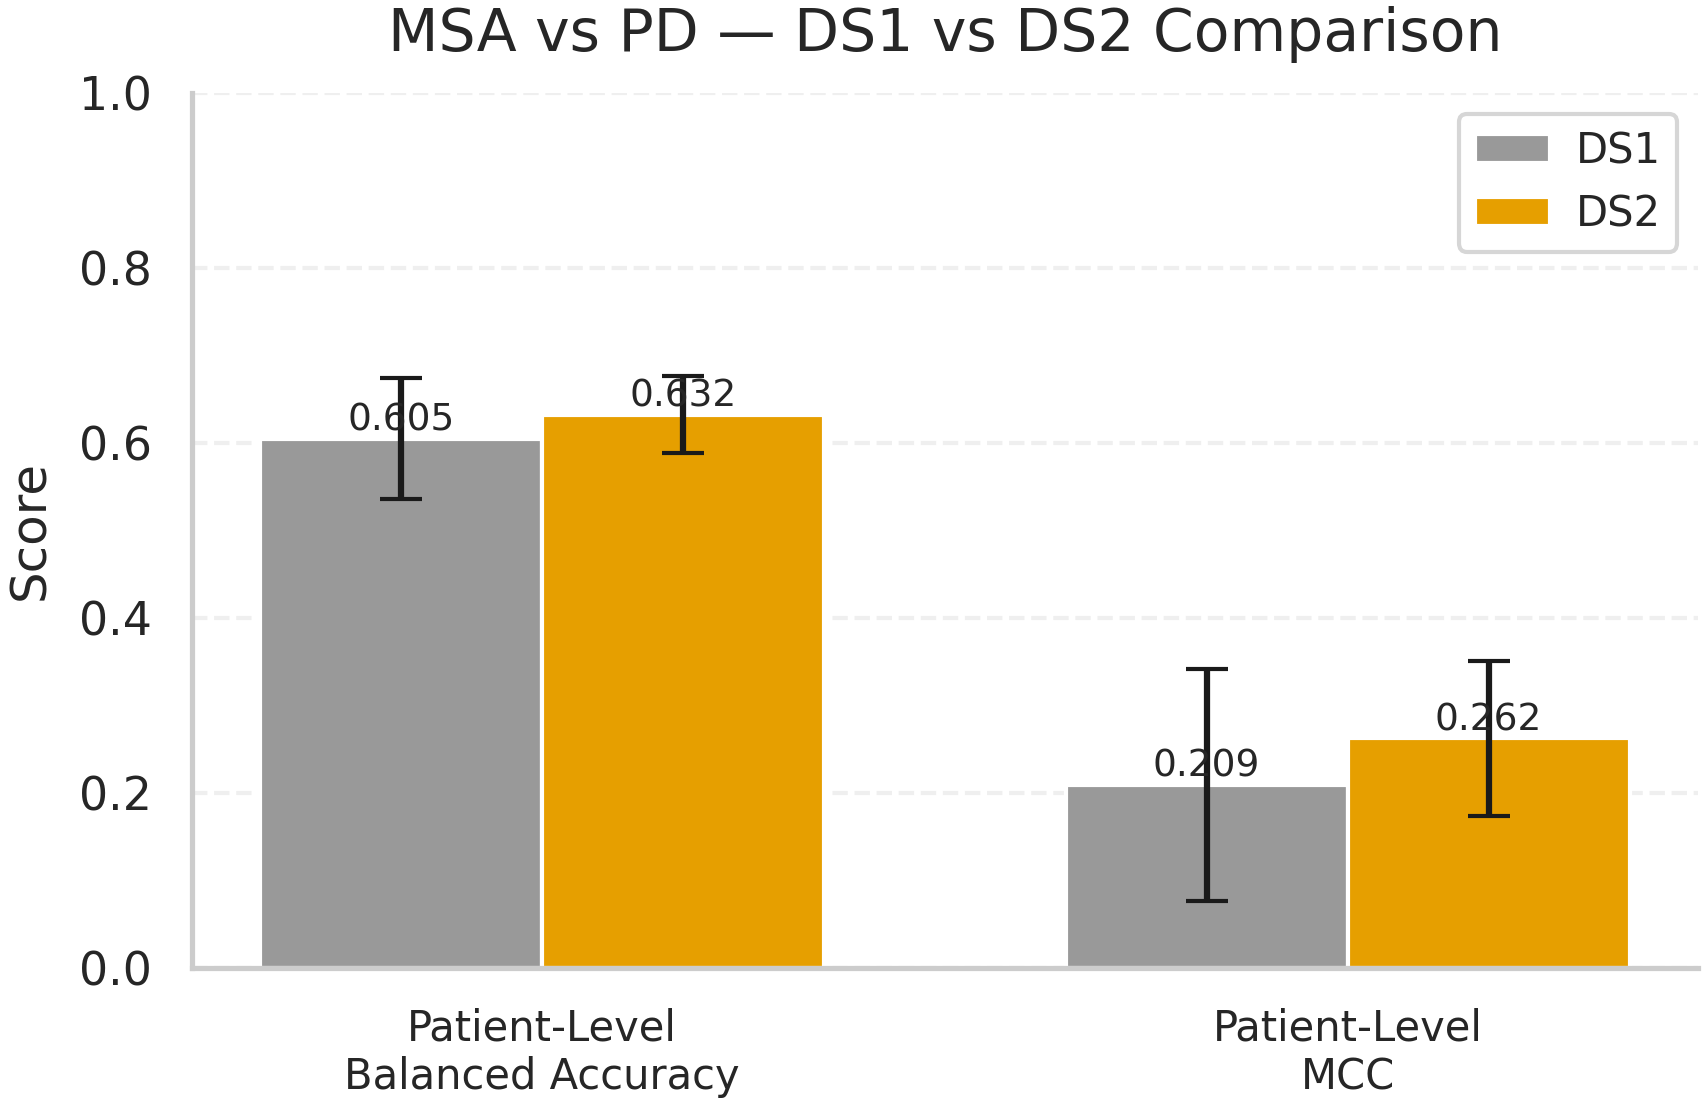


Creating Fig A2: MSA-P vs PD — DS1 vs DS2
Figure saved to images/image_analysis/Fig_A2_MSAP_vs_PD_DS1_vs_DS2.png
Figure saved to images/image_analysis/Fig_A2_MSAP_vs_PD_DS1_vs_DS2.png


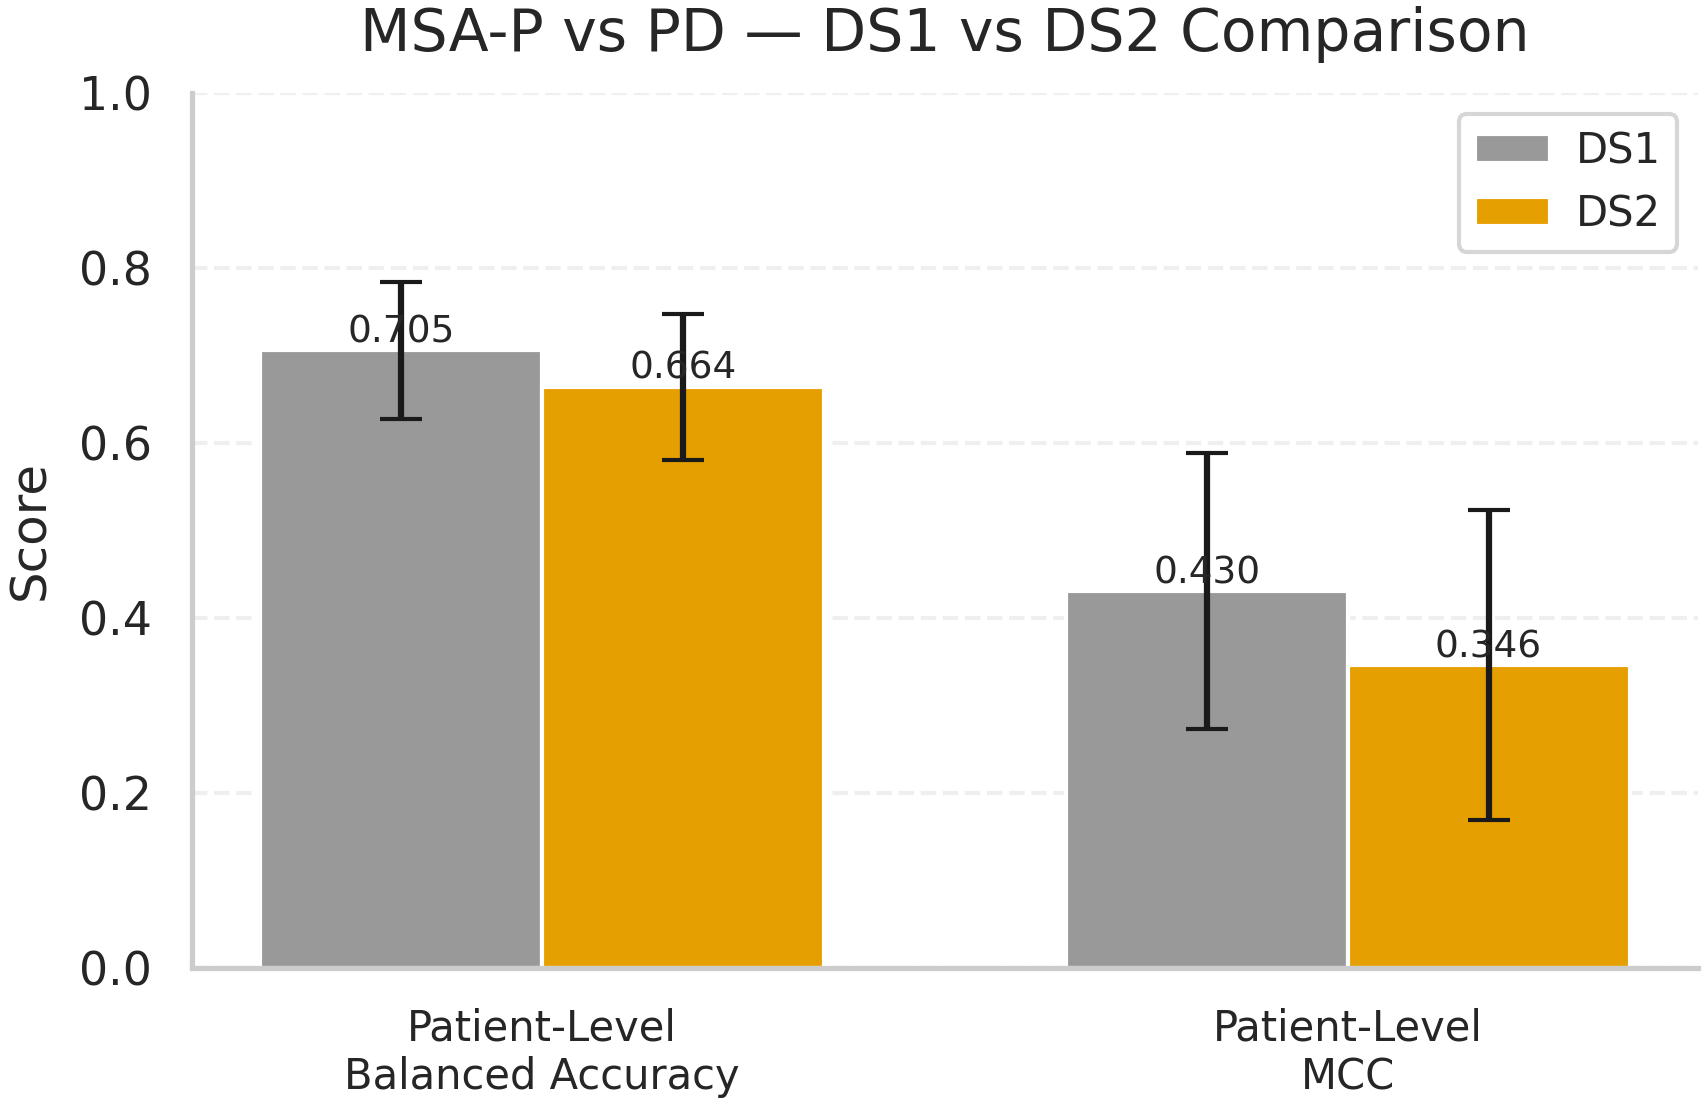

In [591]:
# Extract metrics for Fig A1: MSA vs PD
print("Creating Fig A1: MSA vs PD — DS1 vs DS2")

results_msa_ds1_vs_ds2 = extract_metrics_for_comparison(
    df_ds1_msa, df_ds2_msa, "MSA vs PD"
)

create_comparison_figure(
    results_msa_ds1_vs_ds2,
    "MSA vs PD — DS1 vs DS2 Comparison",
    "Fig_A1_MSA_vs_PD_DS1_vs_DS2.png"
)

# Extract metrics for Fig A2: MSA-P vs PD
print("\nCreating Fig A2: MSA-P vs PD — DS1 vs DS2")
results_msap_ds1_vs_ds2 = extract_metrics_for_comparison(
    df_ds1_msap, df_ds2_msap, "MSA-P vs PD"
)

create_comparison_figure(
    results_msap_ds1_vs_ds2,
    "MSA-P vs PD — DS1 vs DS2 Comparison",
    "Fig_A2_MSAP_vs_PD_DS1_vs_DS2.png"
)

## DS1 Benchmarking

Compare DS1 runs across the main convolutional and transformer backbones and uncover how transfer learning influence patient-level metrics.


In [592]:
# Prepare DS1 backbone analysis data and helper utilities for visualizations
ds1_candidate_names = ["densenet121", "densenet169", "resnet18", "resnet50", "vit"]

architecture_display_names = {
    "densenet121": "Densenet121",
    "densenet169": "Densenet169",
    "resnet18": "Resnet18",
    "resnet50": "Resnet50",
    "vit": "ViT",
}

task_display_names = {
    "MSA vs PD": "MSA vs PD",
    "MSA-P vs PD": "MSA-P vs PD",
}

pretrained_display_names = {
    "imagenet": "ImageNet",
    "imagenet-microscopynet": "ImageNet->MicroscopyNet",
    "microscopynet": "MicroscopyNet",
    "none": "No Pretraining",
}

metrics_to_plot = [
    {
        "metric": "mean_patient_major_bal_acc",
        "std": "std_patient_major_bal_acc",
        "label": "Patient-Level Balanced Accuracy",
        "slug": "bal_acc",
    },
    {
        "metric": "mean_patient_major_mcc",
        "std": "std_patient_major_mcc",
        "label": "Patient-Level MCC",
        "slug": "mcc",
    },
    {
        "metric": "mean_patient_major_precision",
        "std": "std_patient_major_precision",
        "label": "Patient-Level Precision",
        "slug": "precision",
    },
    {
        "metric": "mean_patient_major_recall",
        "std": "std_patient_major_recall",
        "label": "Patient-Level Recall",
        "slug": "recall",
    }
    ,
    {
        "metric": "mean_test_f1",
        "std": "std_test_f1",
        "label": "Image-Level f1",
        "slug": "img_f1",
    },
]

task_slug_map = {
    "MSA vs PD": "msa_vs_pd",
    "MSA-P vs PD": "msap_vs_pd",
}

canonical_arch_order = ["densenet121", "densenet169", "resnet18", "resnet50", "vit"]
task_priority = ["MSA vs PD", "MSA-P vs PD"]

pretraining_priority = [
    "imagenet",
    "imagenet-microscopynet",
    "microscopynet",
]


def canonicalize_model_name(name):
    if not isinstance(name, str):
        return None
    lowered = name.lower()
    if "densenet121" in lowered:
        return "densenet121"
    if "densenet169" in lowered:
        return "densenet169"
    if "resnet18" in lowered:
        return "resnet18"
    if "resnet50" in lowered:
        return "resnet50"
    if "vit" in lowered:
        return "vit"
    return None


def normalize_transfer_learning(value) -> bool:
    if isinstance(value, bool):
        return value
    else:
        lowered = str(value).strip().lower()
        if lowered in {"true", "yes", "1"}:
            return True
        elif lowered in {"false", "no", "0"}:
            return False


def normalize_pretrained(value):
    if pd.isna(value):
        return "none"
    lowered = str(value).strip().lower()
    if lowered in {"", "false", "none", "no"}:
        return "none"
    return lowered


def map_architecture(name):
    if name is None:
        return "Unknown"
    return architecture_display_names.get(name, name.replace("_", " ").title())


def map_task(task):
    if pd.isna(task):
        return "Unknown Task"
    return task_display_names.get(task, task)


def map_pretraining(key):
    if key is None:
        return "No Pretraining"
    return pretrained_display_names.get(key, key.replace("_", " ").title())


def compute_ylim(values, metric_slug):
    if len(values) == 0:
        return 0.0, 1.0
    min_val = float(np.min(values))
    max_val = float(np.max(values))
    lower = min_val - 0.05
    upper = max_val + 0.05
    if metric_slug == "bal_acc":
        lower = max(0.0, lower)
        upper = min(1.05, upper)
    else:
        lower = max(-0.2, lower)
        upper = min(1.05, upper)
    if lower >= upper:
        upper = lower + 0.1
    return lower, upper


def select_best_runs(df, group_cols, metric):
    valid = df.dropna(subset=[metric])
    if valid.empty:
        return valid.copy()
    idx = valid.groupby(group_cols)[metric].idxmax()
    return valid.loc[idx].copy()


def group_stats_for_plot(df, group_cols, metric):
    grouped = (
        df.groupby(group_cols)[metric]
        .agg(mean="mean", std="std", count="count")
        .reset_index()
    )
    grouped["std"] = grouped["std"].fillna(0.0)
    return grouped

In [593]:
if 'transfer_learning' not in results_df.columns:
    results_df['transfer_learning'] = False
# if 'pretrained' not in results_df.columns:
#     results_df['pretrained'] = "none"

ds1_subset = results_df[results_df['dataset'] == 'DS1'].copy()
ds1_subset['model_canonical'] = ds1_subset['model_name'].apply(canonicalize_model_name)
ds1_backbones = ds1_subset[ds1_subset['model_canonical'].isin(canonical_arch_order)].copy()
ds1_backbones = ds1_backbones[ds1_backbones['classes'].isin(task_priority)].copy()

numeric_columns = []
for metric_info in metrics_to_plot:
    numeric_columns.extend([metric_info['metric'], metric_info['std']])
numeric_columns = list(dict.fromkeys(numeric_columns))

for column in numeric_columns:
    if column in ds1_backbones.columns:
        ds1_backbones[column] = pd.to_numeric(ds1_backbones[column], errors='coerce')

ds1_backbones['transfer_learning_bool'] = ds1_backbones['transfer_learning'].apply(normalize_transfer_learning)
ds1_backbones['transfer_label'] = ds1_backbones['transfer_learning_bool'].map({True: 'Transfer Learning', False: 'Scratch'})

ds1_backbones['pretrained_key'] = ds1_backbones['pretrained_weights'].apply(normalize_pretrained)
ds1_backbones['pretrained_label'] = ds1_backbones['pretrained_key'].apply(map_pretraining)

ds1_backbones['architecture_label'] = ds1_backbones['model_canonical'].apply(map_architecture)
ds1_backbones['task_label'] = ds1_backbones['classes'].apply(map_task)

# Prepare output directory for DS1 backbone figures
ds1_arch_output_dir = os.path.join(output_dir, "ds1_architectures")
os.makedirs(ds1_arch_output_dir, exist_ok=True)

print(f"Prepared {len(ds1_backbones)} DS1 runs for backbone analysis.")

Prepared 41 DS1 runs for backbone analysis.


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Assumendo che le seguenti variabili/funzioni siano definite altrove:
# sm, compute_ylim, map_architecture, canonical_arch_order,
# map_task, task_priority, group_stats_for_plot, task_slug_map,
# pretraining_priority, map_pretraining, canonicalize_model_name,
# normalize_transfer_learning, normalize_pretrained, metrics_to_plot,
# output_dir, results_df

def plot_grouped_bar(
    stats_df,
    x_order,
    hue_order,
    metric_label,
    metric_slug,
    title,
    legend_title,
    filename,
    *,
    x_label="CNN Architecture",
    palette=None,
):
    """
    Genera e salva un grafico a barre raggruppate (grouped bar plot) con barre di errore.
    
    (Docstring come fornita in precedenza, è già generica)
    """
    if stats_df.empty:
        print(f"[WARN] Skipping plot '{title}' because no data is available.")
        return
    if not x_order or not hue_order:
        print(f"[WARN] Skipping plot '{title}' due to missing category order.")
        return

    filtered = stats_df[stats_df["x"].isin(x_order) & stats_df["hue"].isin(hue_order)]
    if filtered.empty:
        print(f"[WARN] Skipping plot '{title}' because filtered data is empty.")
        return

    if palette is None:
        palette = [sm.palette[idx % len(sm.palette)] for idx in range(len(hue_order))]
    elif isinstance(palette, dict):
        palette = [palette.get(label, sm.palette[idx % len(sm.palette)]) for idx, label in enumerate(hue_order)]
    else:
        base = list(palette)
        palette = [base[idx % len(base)] for idx in range(len(hue_order))]

    fig, ax = plt.subplots(figsize=(7.2, 4.2))
    width = 0.8 / max(1, len(hue_order))
    offset = (len(hue_order) - 1) / 2.0

    legend_handles = []
    legend_labels = []
    bar_entries = []

    for hue_idx, hue_label in enumerate(hue_order):
        subset = filtered[filtered["hue"] == hue_label]
        if subset.empty:
            continue
        color = palette[hue_idx % len(palette)]
        for x_idx, x_value in enumerate(x_order):
            row = subset[subset["x"] == x_value]
            if row.empty:
                continue
            mean = float(row["mean"].iloc[0])
            std = float(row["std"].iloc[0])
            count = int(row["count"].iloc[0])
            x_pos = x_idx + (hue_idx - offset) * width
            bar = ax.bar(
                x_pos,
                mean,
                width,
                yerr=std,
                capsize=5,
                edgecolor="black",
                color=color,
                alpha=0.9,
            )
            if hue_label not in legend_labels:
                legend_handles.append(bar)
                legend_labels.append(hue_label)
            bar_entries.append(
                {
                    "x_pos": x_pos,
                    "mean": mean,
                    "std": std,
                    "count": count,
                }
            )

    if not bar_entries:
        plt.close(fig)
        print(f"[WARN] Skipping plot '{title}' because no bars were created.")
        return

    y_values = [entry["mean"] for entry in bar_entries]
    y_min = min(entry["mean"] - entry["std"] for entry in bar_entries)
    y_max = max(entry["mean"] + entry["std"] for entry in bar_entries)
    lower, upper = compute_ylim(np.array([y_min, y_max]), metric_slug)
    ax.set_ylim(lower, upper)

    for entry in bar_entries:
        mean = entry["mean"]
        std = entry["std"]
        count = entry["count"]
        text_y = mean + (0.02 if mean >= 0 else -0.02)
        if mean >= 0:
            text_y = min(text_y, upper - 0.01)
            va = "bottom"
        else:
            text_y = max(text_y, lower + 0.01)
            va = "top"
        text = f"{mean:.3f} ± {std:.3f}"
        if count > 1:
            text += f" (n={count})"
        ax.text(entry["x_pos"], text_y, text, ha="center", va=va, fontsize=8.5)

    ax.set_xticks(np.arange(len(x_order)))
    ax.set_xticklabels(x_order)
    ax.set_xlabel(x_label)
    ax.set_ylabel(metric_label)
    ax.set_title(title)
    if legend_labels:
        ax.legend(legend_handles, legend_labels, title=legend_title, frameon=True)
    ax.grid(True, axis="y", alpha=0.3, linestyle="--")
    plt.tight_layout()
    sm.savefig(filename)
    plt.show()  # Display the plot in the notebook
    plt.close(fig)

def plot_architecture_by_task(
    base_df,
    metric,
    metric_label,
    metric_slug,
    dataset_name,
    dataset_output_dir
):
    """
    Crea un bar plot che confronta le performance delle architetture,
    raggruppate per task, per un dataset specifico.

    Args:
        base_df (pd.DataFrame): DataFrame Già' FILTRATO per il dataset di interesse.
        metric (str): Nome colonna metrica (es. 'test_f1').
        metric_label (str): Etichetta asse y (es. "F1-Score (Test)").
        metric_slug (str): Slug per nome file (es. "test_f1").
        dataset_name (str): Nome del dataset (es. "DS1") per titoli e nomi file.
        dataset_output_dir (str): Cartella di output per salvare il grafico.
    """
    plot_df = base_df.dropna(subset=[metric]).copy() # Rimuovi righe senza metrica
    
    if plot_df.empty:
        print(f"[WARN] No {dataset_name} runs with metric '{metric_label}' for architecture plot.")
        return

    architecture_order = [
        map_architecture(name)
        for name in canonical_arch_order
        if map_architecture(name) in plot_df["architecture_label"].unique()
    ]
    
    task_order = [
        map_task(task)
        for task in task_priority
        if map_task(task) in plot_df["task_label"].unique()
    ]
    
    if not architecture_order or not task_order:
        print(f"[WARN] Not enough {dataset_name} data to plot architecture vs task comparison.")
        return

    stats = group_stats_for_plot(
        plot_df,
        ["architecture_label", "task_label"],
        metric,
    ).rename(columns={"architecture_label": "x", "task_label": "hue"})

    output_path = os.path.join(
        dataset_output_dir,
        f"Fig_{dataset_name}_{metric_slug}_architecture_vs_task.png",
    )
    
    plot_grouped_bar(
        stats,
        architecture_order,
        task_order,
        metric_label,
        metric_slug,
        title=f"{dataset_name} — {metric_label} by Architecture",
        legend_title="Task",
        filename=output_path,
    )

def plot_transfer_learning(
    base_df,
    metric,
    metric_label,
    metric_slug,
    dataset_name,
    dataset_output_dir
):
    """
    Crea bar plot (uno per task) che confrontano "Scratch" vs. "Transfer Learning".

    Args:
        base_df (pd.DataFrame): DataFrame GIA' FILTRATO per il dataset di interesse.
        metric (str): Nome colonna metrica (es. 'test_f1').
        metric_label (str): Etichetta asse y (es. "F1-Score (Test)").
        metric_slug (str): Slug per nome file (es. "test_f1").
        dataset_name (str): Nome del dataset (es. "DS1") per titoli e nomi file.
        dataset_output_dir (str): Cartella di output per salvare il grafico.
    """
    available_tasks = [
        map_task(task)
        for task in task_priority
        if map_task(task) in base_df["task_label"].unique()
    ]
    if not available_tasks:
        print(f"[WARN] No {dataset_name} tasks available for transfer learning comparison ({metric_label}).")
        return

    for task_label in available_tasks:
        task_df = base_df[(base_df["task_label"] == task_label)].dropna(subset=[metric])
        if task_df.empty:
            print(f"[WARN] No {dataset_name} runs for transfer learning comparison ({metric_label}) in task '{task_label}'.")
            continue

        architecture_order = [
            arch
            for arch in [map_architecture(name) for name in canonical_arch_order]
            if arch in task_df["architecture_label"].unique()
        ]
        transfer_order = [
            label
            for label in ["Scratch", "Transfer Learning"]
            if label in task_df["transfer_label"].unique()
        ]
        if not architecture_order or not transfer_order:
            print(f"[WARN] Skipping transfer learning plot for task '{task_label}' (insufficient categories).")
            continue

        stats = group_stats_for_plot(
            task_df,
            ["architecture_label", "transfer_label"],
            metric,
        ).rename(columns={"architecture_label": "x", "transfer_label": "hue"})

        palette = {
            "Scratch": sm.palette[1] if len(sm.palette) > 1 else "#999999",
            "Transfer Learning": sm.palette[0] if len(sm.palette) > 0 else "#0072B2",
        }
        task_slug = task_slug_map.get(task_label, task_label.lower().replace(" ", "_").replace("-", ""))
        output_path = os.path.join(
            dataset_output_dir,
            f"Fig_{dataset_name}_{metric_slug}_transfer_{task_slug}.png",
        )
        plot_grouped_bar(
            stats,
            architecture_order,
            transfer_order,
            metric_label,
            metric_slug,
            title=f"{dataset_name} — {metric_label} ({task_label})",
            legend_title="Training Regime",
            filename=output_path,
            palette=palette,
        )

def plot_pretraining_weights(
    base_df,
    metric,
    metric_label,
    metric_slug,
    dataset_name,
    dataset_output_dir
):
    """
    Crea bar plot (uno per task) che confrontano l'impatto di diversi
    pesi di pre-addestramento (es. ImageNet, SWAV).

    Args:
        base_df (pd.DataFrame): DataFrame GIA' FILTRATO per il dataset di interesse.
        metric (str): Nome colonna metrica (es. 'test_f1').
        metric_label (str): Etichetta asse y (es. "F1-Score (Test)").
        metric_slug (str): Slug per nome file (es. "test_f1").
        dataset_name (str): Nome del dataset (es. "DS1") per titoli e nomi file.
        dataset_output_dir (str): Cartella di output per salvare il grafico.
    """
    transfer_runs = base_df[base_df["transfer_learning_bool"]].copy()
    transfer_runs = transfer_runs[transfer_runs["pretrained_label"] != "No Pretraining"]
    if transfer_runs.empty:
        print(f"[WARN] No {dataset_name} transfer learning runs with explicit pretraining for {metric_label}.")
        return

    available_tasks = [
        map_task(task)
        for task in task_priority
        if map_task(task) in transfer_runs["task_label"].unique()
    ]
    if not available_tasks:
        print(f"[WARN] No {dataset_name} tasks available for pretraining comparison ({metric_label}).")
        return

    for task_label in available_tasks:
        task_df = transfer_runs[(transfer_runs["task_label"] == task_label)].dropna(subset=[metric])
        if task_df.empty:
            print(f"[WARN] No {dataset_name} runs for pretraining comparison ({metric_label}) in task '{task_label}'.")
            continue

        architecture_order = [
            arch
            for arch in [map_architecture(name) for name in canonical_arch_order]
            if arch in task_df["architecture_label"].unique()
        ]
        pretraining_order = [
            map_pretraining(key)
            for key in pretraining_priority
            if map_pretraining(key) in task_df["pretrained_label"].unique()
        ]
        if not pretraining_order:
            pretraining_order = sorted(task_df["pretrained_label"].unique())
        if not architecture_order or not pretraining_order:
            print(f"[WARN] Skipping pretraining plot for task '{task_label}' (insufficient categories).")
            continue

        stats = group_stats_for_plot(
            task_df,
            ["architecture_label", "pretrained_label"],
            metric,
        ).rename(columns={"architecture_label": "x", "pretrained_label": "hue"})

        palette = [sm.palette[idx % len(sm.palette)] for idx in range(len(pretraining_order))]
        task_slug = task_slug_map.get(task_label, task_label.lower().replace(" ", "_").replace("-", ""))
        output_path = os.path.join(
            dataset_output_dir,
            f"Fig_{dataset_name}_{metric_slug}_pretraining_{task_slug}.png",
        )
        plot_grouped_bar(
            stats,
            architecture_order,
            pretraining_order,
            metric_label,
            metric_slug,
            title=f"{dataset_name} — {metric_label} ({task_label})",
            legend_title="Pretraining Weights",
            filename=output_path,
            palette=palette,
        )

def plot_architecture_boxplot(
    base_df,
    metric,
    metric_label,
    metric_slug,
    dataset_name,
    dataset_output_dir
):
    """
    Crea un boxplot che mostra la distribuzione delle performance per
    ciascuna architettura, raggruppate per task.

    Args:
        base_df (pd.DataFrame): DataFrame GIA' FILTRATO per il dataset di interesse.
        metric (str): Nome colonna metrica (es. 'test_f1').
        metric_label (str): Etichetta asse y (es. "F1-Score (Test)").
        metric_slug (str): Slug per nome file (es. "test_f1").
        dataset_name (str): Nome del dataset (es. "DS1") per titoli e nomi file.
        dataset_output_dir (str): Cartella di output per salvare il grafico.
    """
    plot_df = base_df.dropna(subset=[metric]).copy()
    if plot_df.empty:
        print(f"[WARN] No {dataset_name} runs with metric '{metric_label}' for architecture boxplot.")
        return

    architecture_order = [
        map_architecture(name)
        for name in canonical_arch_order
        if map_architecture(name) in plot_df["architecture_label"].unique()
    ]
    task_order = [
        map_task(task)
        for task in task_priority
        if map_task(task) in plot_df["task_label"].unique()
    ]
    if not architecture_order or not task_order:
        print(f"[WARN] Not enough {dataset_name} data to plot boxplot by architecture.")
        return

    fig, ax = plt.subplots(figsize=(7.5, 4.2))
    palette = [sm.palette[idx % len(sm.palette)] for idx in range(len(task_order))]
    sns.boxplot(
        data=plot_df,
        x="architecture_label",
        y=metric,
        hue="task_label",
        order=architecture_order,
        hue_order=task_order,
        palette=palette,
        ax=ax,
    )
    ax.set_xlabel("Backbone Architecture")
    ax.set_ylabel(metric_label)
    ax.set_title(f"{dataset_name} — {metric_label} Distribution by Architecture")
    ax.grid(True, axis="y", alpha=0.3, linestyle="--")
    ax.legend(title="Task", frameon=True)
    plt.tight_layout()
    output_path = os.path.join(
        dataset_output_dir,
        f"Fig_{dataset_name}_{metric_slug}_architecture_boxplot.png",
    )
    sm.savefig(output_path)
    plt.show()  # Display the plot in the notebook
    plt.close(fig)

def plot_pretraining_boxplot(
    base_df,
    metric,
    metric_label,
    metric_slug,
    dataset_name,
    dataset_output_dir
):
    """
    Crea un boxplot che mostra la distribuzione delle performance per
    diversi pesi di pre-addestramento, raggruppati per architettura.

    Args:
        base_df (pd.DataFrame): DataFrame GIA' FILTRATO per il dataset di interesse.
        metric (str): Nome colonna metrica (es. 'test_f1').
        metric_label (str): Etichetta asse y (es. "F1-Score (Test)").
        metric_slug (str): Slug per nome file (es. "test_f1").
        dataset_name (str): Nome del dataset (es. "DS1") per titoli e nomi file.
        dataset_output_dir (str): Cartella di output per salvare il grafico.
    """
    transfer_runs = base_df[base_df["transfer_learning_bool"]].copy()
    transfer_runs = transfer_runs[transfer_runs["pretrained_label"] != "No Pretraining"]
    transfer_runs = transfer_runs.dropna(subset=[metric])
    if transfer_runs.empty:
        print(f"[WARN] No {dataset_name} transfer runs with pretraining found for boxplot ({metric_label}).")
        return

    architecture_order = [
        map_architecture(name)
        for name in canonical_arch_order
        if map_architecture(name) in transfer_runs["architecture_label"].unique()
    ]
    pretraining_order = [
        map_pretraining(key)
        for key in pretraining_priority
        if map_pretraining(key) in transfer_runs["pretrained_label"].unique()
    ]
    if not pretraining_order:
        pretraining_order = sorted(transfer_runs["pretrained_label"].unique())
    if not architecture_order or not pretraining_order:
        print(f"[WARN] Not enough {dataset_name} data to plot pretraining boxplot.")
        return

    fig, ax = plt.subplots(figsize=(7.5, 4.2))
    palette = [sm.palette[idx % len(sm.palette)] for idx in range(len(architecture_order))]
    sns.boxplot(
        data=transfer_runs,
        x="pretrained_label",
        y=metric,
        hue="architecture_label",
        order=pretraining_order,
        hue_order=architecture_order,
        palette=palette,
        ax=ax,
    )
    ax.set_xlabel("Pretraining Weights")
    ax.set_ylabel(metric_label)
    ax.set_title(f"{dataset_name} — {metric_label} by Pretraining Weights")
    ax.grid(True, axis="y", alpha=0.3, linestyle="--")
    ax.legend(title="Backbone", frameon=True)
    plt.tight_layout()
    output_path = os.path.join(
        dataset_output_dir,
        f"Fig_{dataset_name}_{metric_slug}_pretraining_boxplot.png",
    )
    sm.savefig(output_path)
    plt.show()  # Display the plot in the notebook
    plt.close(fig)

print("Starting backbone analysis...")

# --- Setup Iniziale (sul DataFrame principale) ---
if 'transfer_learning' not in results_df.columns:
    results_df['transfer_learning'] = False
if 'pretrained_weights' not in results_df.columns:
    results_df['pretrained_weights'] = "none"

# Pre-calcola le colonne numeriche
numeric_columns = []
for metric_info in metrics_to_plot:
    numeric_columns.extend([metric_info['metric'], metric_info['std']])
numeric_columns = list(dict.fromkeys(numeric_columns))


# --- Loop di Analisi per Ciascun Dataset ---
datasets_to_analyze = ['DS1', 'DS2'] # Aggiungi qui altri dataset se necessario

for ds_name in datasets_to_analyze:
    print(f"\n--- Processing analysis for dataset: {ds_name} ---")
    
    # 1. Filtra per il dataset corrente
    ds_subset = results_df[results_df['dataset'] == ds_name].copy()
    
    if ds_subset.empty:
        print(f"[INFO] No data found for dataset '{ds_name}'. Skipping.")
        continue

    # 2. Applica la preparazione dei dati sul dataset specifico 
    ds_subset['model_canonical'] = ds_subset['model_name'].apply(canonicalize_model_name)
    # Filtra per architetture e task di interesse
    ds_architectures = ds_subset[ds_subset['model_canonical'].isin(canonical_arch_order)].copy()
    # ds_architectures = ds_architectures[ds_architectures['classes'].isin(task_priority)].copy()

    if ds_architectures.empty:
        print(f"[INFO] No valid architecture runs found for '{ds_name}'. Skipping.")
        continue

    for column in numeric_columns:
        if column in ds_architectures.columns:
            ds_architectures[column] = pd.to_numeric(ds_architectures[column], errors='coerce')

    ds_architectures['transfer_learning_bool'] = ds_architectures['transfer_learning'].apply(normalize_transfer_learning)
    ds_architectures['transfer_label'] = ds_architectures['transfer_learning_bool'].map({True: 'Transfer Learning', False: 'Scratch'})
    ds_architectures['pretrained_key'] = ds_architectures['pretrained_weights'].apply(normalize_pretrained)
    ds_architectures['pretrained_label'] = ds_architectures['pretrained_key'].apply(map_pretraining)
    ds_architectures['architecture_label'] = ds_architectures['model_canonical'].apply(map_architecture)
    ds_architectures['task_label'] = ds_architectures['classes'].apply(map_task)
    print(ds_architectures.columns.tolist())
    # 3. Prepara la cartella di output
    ds_arch_output_dir = os.path.join(output_dir, f"{ds_name.lower()}_architectures")
    os.makedirs(ds_arch_output_dir, exist_ok=True)

    print(f"Prepared {len(ds_architectures)} {ds_name} runs for backbone analysis.")
    
    #save a preview of the dataframe to csv 
    # ds_architectures.to_csv(os.path.join(ds_arch_output_dir, f"{ds_name}_backbone_analysis_data.csv"), index=False)
    # print("saved to path :", os.path.join(ds_arch_output_dir, f"{ds_name}_backbone_analysis_data.csv"))
    # display(ds_architectures.head())

    # 4. Esegui il plotting per tutte le metriche
    for metric_info in metrics_to_plot:
        metric = metric_info['metric']
        metric_label = metric_info['label']
        metric_slug = metric_info['slug']
        
        print(f"  Plotting {metric_label} for {ds_name}...")
        
        # Chiama le nuove funzioni generiche
        plot_architecture_by_task(
            base_df=ds_architectures,
            metric=metric,
            metric_label=metric_label,
            metric_slug=metric_slug,
            dataset_name=ds_name,
            dataset_output_dir=ds_arch_output_dir
        )
        
        plt.show()
        
        # plot_transfer_learning(
        #     base_df=ds_architectures,
        #     metric=metric,
        #     metric_label=metric_label,
        #     metric_slug=metric_slug,
        #     dataset_name=ds_name,
        #     dataset_output_dir=ds_arch_output_dir
        # )
        
        # plot_pretraining_weights(
        #     base_df=ds_architectures,
        #     metric=metric,
        #     metric_label=metric_label,
        #     metric_slug=metric_slug,
        #     dataset_name=ds_name,
        #     dataset_output_dir=ds_arch_output_dir
        # )

        # plot_architecture_boxplot(
        #     base_df=ds_architectures,
        #     metric=metric,
        #     metric_label=metric_label,
        #     metric_slug=metric_slug,
        #     dataset_name=ds_name,
        #     dataset_output_dir=ds_arch_output_dir
        # )
        
        # plot_pretraining_boxplot(
        #     base_df=ds_architectures,
        #     metric=metric,
        #     metric_label=metric_label,
        #     metric_slug=metric_slug,
        #     dataset_name=ds_name,
        #     dataset_output_dir=ds_arch_output_dir
        # )

# print("\n--- Backbone analysis complete ---")

In [595]:
ds1_backbones

,experiment_name,run_name,dataset,classes,num_channels,best_lr,dropout_rate,epochs,freezed_layer_index,intensity_augmentation_preset,lr_discovery_folds,mixup_alpha,model_library,model_name,optimizer_name,pretrained_weights,test_counts,test_pat_ids_for_best_fold,test_pat_ids_per_fold,total_params,train_counts,trainable_params,transfer_learning,val_counts,weight_decay,mean_patient_major_bal_acc,mean_patient_major_mcc,mean_patient_major_precision,mean_patient_major_recall,mean_patient_soft_bal_acc,mean_patient_soft_mcc,mean_patient_soft_precision,mean_patient_soft_recall,mean_test_accuracy,mean_test_auc,mean_test_balanced_acc,mean_test_f1,mean_test_mcc,mean_test_precision,mean_test_recall,patient_major_bal_acc_formatted,patient_major_mcc_formatted,patient_major_precision_formatted,patient_major_recall_formatted,patient_soft_bal_acc_formatted,patient_soft_mcc_formatted,patient_soft_precision_formatted,patient_soft_recall_formatted,std_patient_major_bal_acc,std_patient_major_mcc,std_patient_major_precision,std_patient_major_recall,std_patient_soft_bal_acc,std_patient_soft_mcc,std_patient_soft_precision,std_patient_soft_recall,std_test_accuracy,std_test_auc,std_test_balanced_acc,std_test_f1,std_test_mcc,std_test_precision,std_test_recall,patient_major_bal_acc_formatted,patient_major_mcc_formatted,patient_major_precision_formatted,patient_major_recall_formatted,patient_soft_bal_acc_formatted,patient_soft_mcc_formatted,patient_soft_precision_formatted,patient_soft_recall_formatted,test_accuracy_formatted,test_auc_formatted,test_balanced_acc_formatted,test_f1_formatted,test_mcc_formatted,test_precision_formatted,test_recall_formatted,model_canonical,transfer_learning_bool,transfer_label,pretrained_key,pretrained_label,architecture_label,task_label
89,DS1_3c_MSA-P_vs_PD_supervised,Densenet169_oversamp_torchvision_10-30_at:03-2...,DS1,MSA-P vs PD,3,0.00012207764786954147,0.2,150,None,light,4,0,torchvision,Densenet169,Adam,imagenet,14,['5463' '5978' '6323' '6577' '6599' '6696' '67...,"{0: array(['5776', '5878', '6008', '6053', '60...",12487810,"{0: 91, 1: 91, 2: 91, 3: 91, 4: 91, 5: 89, 6: ...",12487810,False,"{0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...",1e-4,0.778,0.579,0.747,0.875,0.713,0.443,0.642,0.812,0.713,0.798,0.721,0.729,0.452,0.677,0.807,0.778,0.579,0.747,0.875,0.713,0.443,0.642,0.812,0.153,0.293,0.212,0.125,0.149,0.309,0.155,0.242,0.135,0.146,0.128,0.126,0.259,0.142,0.138,0.778 ± 0.153,0.579 ± 0.293,0.747 ± 0.212,0.875 ± 0.125,0.713 ± 0.149,0.443 ± 0.309,0.642 ± 0.155,0.812 ± 0.242,0.713 ± 0.135,0.798 ± 0.146,0.721 ± 0.128,0.729 ± 0.126,0.452 ± 0.259,0.677 ± 0.142,0.807 ± 0.138,densenet169,False,Scratch,imagenet,ImageNet,Densenet169,MSA-P vs PD
91,DS1_3c_MSA-P_vs_PD_supervised,Densenet121_oversamp_torchvision_10-30_at:00-5...,DS1,MSA-P vs PD,3,0.00012207764786954147,0.2,150,None,light,4,0,torchvision,Densenet121,Adam,imagenet,14,['5358' '6258' '6340' '6427' '6593' '6749' '73...,"{0: array(['5776', '5878', '6008', '6053', '60...",6955906,"{0: 91, 1: 91, 2: 91, 3: 91, 4: 91, 5: 89, 6: ...",6955906,False,"{0: 18, 1: 19, 2: 17, 3: 17, 4: 17, 5: 18, 6: ...",1e-4,0.609,0.241,0.325,0.281,0.562,0.148,0.283,0.219,0.580,0.682,0.579,0.239,0.170,0.265,0.250,0.609,0.241,0.325,0.281,0.562,0.148,0.283,0.219,0.170,0.350,0.435,0.423,0.088,0.204,0.381,0.341,0.120,0.132,0.120,0.331,0.250,0.349,0.375,0.609 ± 0.170,0.241 ± 0.350,0.325 ± 0.435,0.281 ± 0.423,0.562 ± 0.088,0.148 ± 0.204,0.283 ± 0.381,0.219 ± 0.341,0.58 ± 0.12,0.682 ± 0.132,0.579 ± 0.12,0.239 ± 0.331,0.17 ± 0.25,0.265 ± 0.349,0.25 ± 0.375,densenet121,False,Scratch,imagenet,ImageNet,Densenet121,MSA-P vs PD
90,DS1_3c_MSA-P_vs_PD_supervised,Densenet121_oversamp_torchvision_10-30_at:02-2...,DS1,MSA-P vs PD,3,0.00012207764786954147,0.2,150,None,light,4,0,torchvision,Densenet121,Adam,imagenet,14,['5463' '5978' '6323' '6577' '6599' '6696' '67...,"{0: array(['5776', '5878', '6008', '6053', '60...",6955906,"{0: 91, 1: 91, 2: 91, 3: 91, 4: 91, 5: 89, 6: ...",6955906,False,"{0: 18, 1: 19, 2

In [ ]:
best_balanced = select_best_runs(ds1_backbones, ['model_canonical', 'classes'], 'mean_patient_major_bal_acc')
if not best_balanced.empty:
    summary_cols = [
        'architecture_label',
        'task_label',
        'transfer_label',
        'pretrained_label',
        'mean_patient_major_bal_acc',
        'std_patient_major_bal_acc',
        'mean_patient_major_mcc',
        'std_patient_major_mcc',
    ]
    summary_table = (
        best_balanced[summary_cols]
        .rename(
            columns={
                'architecture_label': 'Backbone',
                'task_label': 'Task',
                'transfer_label': 'Transfer Learning',
                'pretrained_label': 'Pretraining',
                'mean_patient_major_bal_acc': 'Patient Balanced Acc. Mean',
                'std_patient_major_bal_acc': 'Patient Balanced Acc. Std',
                'mean_patient_major_mcc': 'Patient MCC Mean',
                'std_patient_major_mcc': 'Patient MCC Std',
            }
        )
        .sort_values('Patient Balanced Acc. Mean', ascending=False)
        .reset_index(drop=True)
    )
    summary_table = summary_table.round(
        {
            'Patient Balanced Acc. Mean': 3,
            'Patient Balanced Acc. Std': 3,
            'Patient MCC Mean': 3,
            'Patient MCC Std': 3,
        }
    )
    display(summary_table)
else:
    print("No DS1 balanced accuracy runs available for summary.")

Figure saved to images/image_analysis/ds1_architectures/Fig_DS1_bal_acc_architecture_vs_task.png
Figure saved to images/image_analysis/ds1_architectures/Fig_DS1_bal_acc_transfer_msa_vs_pd.png
Figure saved to images/image_analysis/ds1_architectures/Fig_DS1_bal_acc_transfer_msap_vs_pd.png
Figure saved to images/image_analysis/ds1_architectures/Fig_DS1_bal_acc_pretraining_msa_vs_pd.png
Figure saved to images/image_analysis/ds1_architectures/Fig_DS1_bal_acc_transfer_msap_vs_pd.png
Figure saved to images/image_analysis/ds1_architectures/Fig_DS1_bal_acc_pretraining_msa_vs_pd.png
Figure saved to images/image_analysis/ds1_architectures/Fig_DS1_bal_acc_pretraining_msap_vs_pd.png
Figure saved to images/image_analysis/ds1_architectures/Fig_DS1_bal_acc_architecture_boxplot.png
Figure saved to images/image_analysis/ds1_architectures/Fig_DS1_bal_acc_pretraining_msap_vs_pd.png
Figure saved to images/image_analysis/ds1_architectures/Fig_DS1_bal_acc_architecture_boxplot.png
Figure saved to images/image

,Backbone,Task,Transfer Learning,Pretraining,Patient Balanced Acc. Mean,Patient Balanced Acc. Std,Patient MCC Mean,Patient MCC Std
0,Densenet121,MSA-P vs PD,Scratch,No Pretraining,0.818,0.141,0.650,0.287
1,Densenet169,MSA-P vs PD,Scratch,No Pretraining,0.792,0.174,0.592,0.350
2,Resnet18,MSA-P vs PD,Scratch,No Pretraining,0.792,0.172,0.593,0.344
3,ViT,MSA-P vs PD,Scratch,No Pretraining,0.750,0.217,0.527,0.437
4,Densenet169,MSA vs PD,Scratch,ImageNet,0.731,0.157,0.447,0.300
5,Densenet121,MSA vs PD,Scratch,ImageNet,0.724,0.144,0.437,0.276
6,Resnet18,MSA vs PD,Transfer Learning,MicroscopyNet,0.642,0.139,0.272,0.265
7,ViT,MSA vs PD,Scratch,No Pretraining,0.555,0.152,0.136,0.330


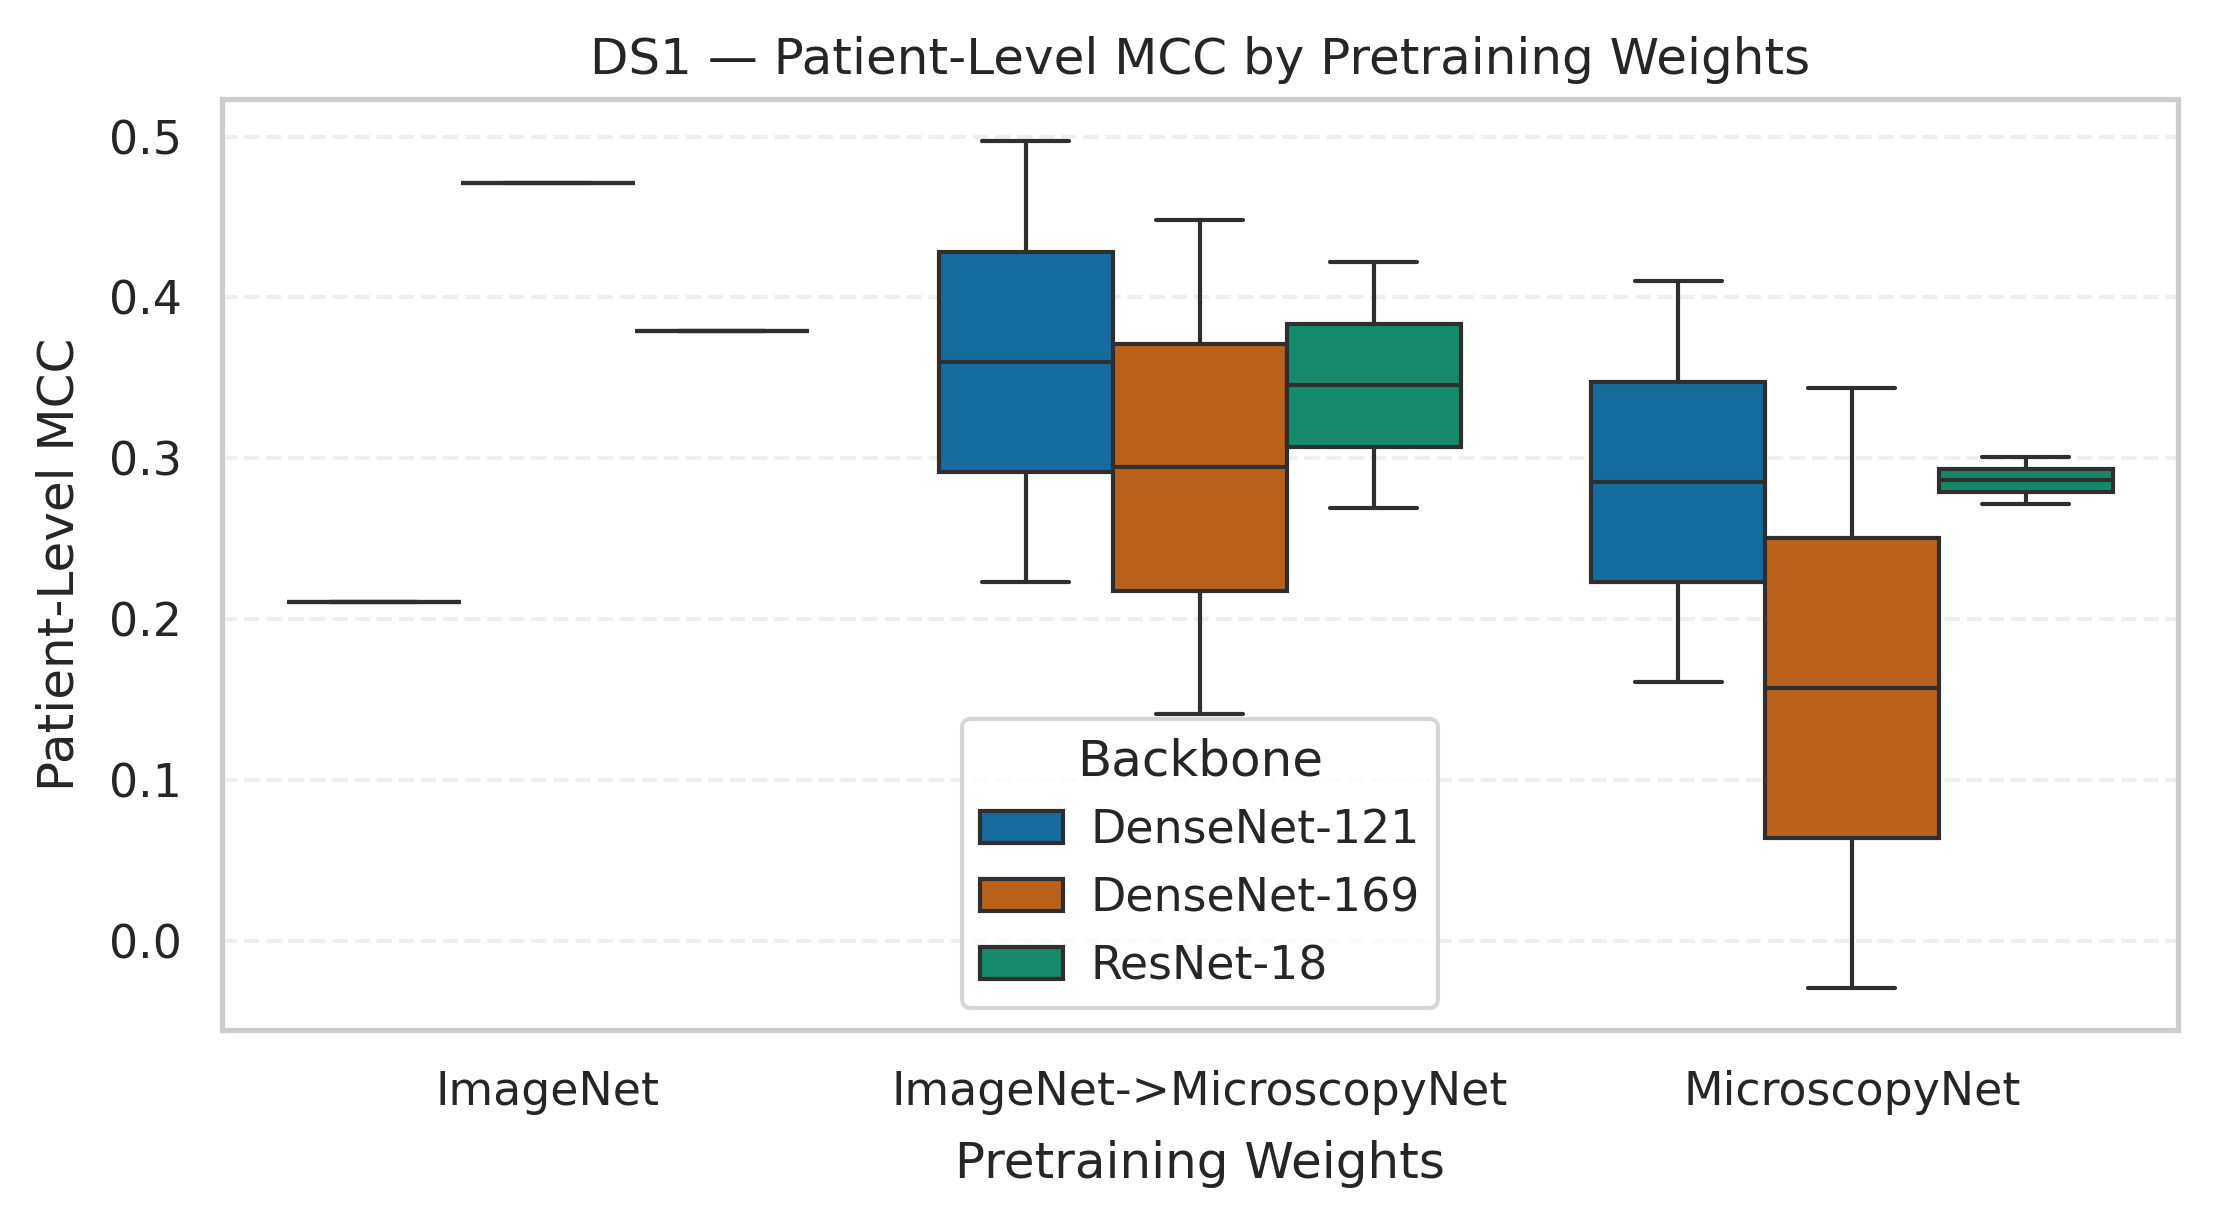

In [ ]:
from IPython.display import Image, display
display(Image("images/image_analysis/ds1_architectures/Fig_DS1_mcc_pretraining_boxplot.png"))